# Main Notebook

## Importing Data and Rotating Coordinates

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.cm as cm

import astropy.coordinates as coord
from astropy.table import Table, vstack
from astropy.io import fits
import astropy.units as u
from astropy.coordinates import Angle

import pickle
import pandas as pd

coord.galactocentric_frame_defaults.set('v4.0')
import galstreams
import gala.coordinates as gc
import gala.potential as gp
import gala.dynamics as gd
from gala.units import galactic
from gala.dynamics.nbody import DirectNBody
import gala.integrate as gi

%matplotlib inline
%config InlineBackend.figure_format='retina'

from helpers.SimulationAnalysis import SimulationAnalysis, iterTrees
from helpers.SimulationAnalysis import readHlist

In [2]:
gsr = coord.Galactocentric()
mwsts = galstreams.MWStreams(verbose=False, implement_Off=False)

Initializing galstreams library from master_log... 


In [3]:
#Path to simulation data
path_to_data = ''

#Halo properties to load; see Section 2.4 of https://arxiv.org/abs/2008.08591 for info on Rockstar fields 
fields = ['scale','id', 'upid', 'pid', 'mvir', 'mpeak', 'rvir', 'RVmax', 'rs', 'vmax', 'vpeak', 'x', 'y', 'z', 'vx', 'vy', 'vz',
          'M200c', 'depth_first_id','scale_of_last_MM']

#Load z = 0 halo list for Halo416_16K
halos_z0 = readHlist(path_to_data+'hlist_1.00000.list',fields=fields) #0.97483 
MW_analog = halos_z0[np.argmax(halos_z0['mvir'])]

subhalos_z0 = halos_z0[halos_z0['upid']==MW_analog['id']]
LMC_analog = subhalos_z0[np.argmax(subhalos_z0['mvir'])]


#Reading in data from dm particles
t = Table.read('snapshot_now.fits')

# ind_lmc = subhalos_z0['pid']==LMC_analog['id']
ind_lmc = np.argmax(subhalos_z0['mvir'])



In [4]:
h = 0.7
ts = Table(subhalos_z0)
for comp in ['x', 'y', 'z']:
    ts[comp] = ((ts[comp] - MW_analog[comp])*u.Mpc/h).to(u.kpc)
for comp in ['vx', 'vy', 'vz']:
    ts[comp] = (ts[comp] - MW_analog[comp])*u.km/u.s

In [5]:
ind_massive = (ts['mvir'] > 10**7)
len(ts['mvir'][ind_massive])

1072

In [6]:
c = coord.Galactocentric(x=ts['x'][ind_massive], y=ts['y'][ind_massive], z=ts['z'][ind_massive],
                         v_x=ts['vx'][ind_massive], v_y=ts['vy'][ind_massive], v_z=ts['vz'][ind_massive])
ceq = c.transform_to(coord.ICRS()) 

ceq_lmc = coord.ICRS(ra=78.76*u.deg, dec=-69.19*u.deg, distance=(10**(0.2*18.50+1)*u.pc).to(u.kpc), 
                     radial_velocity=262.2*u.km/u.s, pm_ra_cosdec=1.91*u.mas/u.yr, pm_dec=0.229*u.mas/u.yr)
c_lmc = ceq_lmc.transform_to(coord.Galactocentric()) #galactocentric coordinates

In [7]:
vsim = np.array([c.x.value[ind_lmc], c.y.value[ind_lmc], c.z.value[ind_lmc]]) #this is the u vector 
vsim = vsim / np.linalg.norm(vsim)

vtrue = np.array([c_lmc.x.value, c_lmc.y.value, c_lmc.z.value]) #this is the v vector 
vtrue = vtrue / np.linalg.norm(vtrue)

vpole = np.cross(vsim, vtrue)
vpole = vpole / np.linalg.norm(vpole)

In [8]:
theta = np.arccos(np.dot(vsim,vtrue)/(np.linalg.norm(vsim)*np.linalg.norm(vtrue)))

#ROTATION MATRIX
R = np.array([[np.cos(theta) + vpole[0]**2*(1-np.cos(theta)),
              vpole[0]*vpole[1]*(1-np.cos(theta)) - vpole[2]*np.sin(theta),
              vpole[0]*vpole[2]*(1-np.cos(theta)) + vpole[1]*np.sin(theta)],
             [vpole[1]*vpole[0]*(1-np.cos(theta)) + vpole[2]*np.sin(theta),
              np.cos(theta) + vpole[1]**2*(1-np.cos(theta)),
              vpole[1]*vpole[2]*(1-np.cos(theta)) - vpole[0]*np.sin(theta)],
             [vpole[2]*vpole[0]*(1-np.cos(theta)) - vpole[1]*np.sin(theta),
              vpole[2]*vpole[1]*(1-np.cos(theta)) + vpole[0]*np.sin(theta),
              np.cos(theta) + vpole[2]**2*(1-np.cos(theta))]])

In [9]:
trot = Table(subhalos_z0[ind_massive])
N = len(trot)
trot['x'] = np.zeros(N)#*u.kpc
trot['y'] = np.zeros(N)#*u.kpc
trot['z'] = np.zeros(N)#*u.kpc

for i in range(N):
    temp_vec = np.array([ts['x'][ind_massive][i], ts['y'][ind_massive][i], ts['z'][ind_massive][i]])
    rot_vec = np.matmul(R, temp_vec)
    
    trot['x'][i] = rot_vec[0]#*u.kpc
    trot['y'][i] = rot_vec[1]#*u.kpc
    trot['z'][i] = rot_vec[2]#*u.kpc

In [10]:
#This is the radius from the center at which the maximum velocity occurs
trot['rs'] = (trot['RVmax'])/2.163

In [11]:
subhalo_dist=np.sqrt(trot['x']**2+trot['y']**2+trot['z']**2)

In [12]:
ham = gp.Hamiltonian(gp.NFWPotential(m=MW_analog['mvir']/h*u.Msun, 
                                     r_s=(MW_analog['rs'])/h*u.kpc, units=galactic))


In [13]:
#Getting the Orbits of Subhalos
dt = 1*u.Myr
subh_orbits = []
Nstep_long=3000
for subh in range(len(ts['x'][ind_massive])): 
    #This calculates the position of the subhalos at a given time
    c_subh = coord.Galactocentric(x=ts['x'][ind_massive][subh]*u.kpc, y=ts['y'][ind_massive][subh]*u.kpc, 
                                  z=ts['z'][ind_massive][subh]*u.kpc,
                                  v_x=ts['vx'][ind_massive][subh]*u.km/u.s, 
                                  v_y=ts['vy'][ind_massive][subh]*u.km/u.s,
                                  v_z=ts['vz'][ind_massive][subh]*u.km/u.s)
    w0_subh = gd.PhaseSpacePosition(c_subh.cartesian)
    subh_orbits += [ham.integrate_orbit(w0_subh, dt=-dt, n_steps=Nstep_long)]

In [14]:
#Rotating Subhalo Orbits 
N = len(subh_orbits[0].pos.x)

rot_orbits=np.zeros((len(ts['x'][ind_massive]), len(subh_orbits[1].pos.x), 3))

for j, subh in enumerate(subh_orbits):
    for i in range(N):
        temp_vec = np.array([subh.pos.x[i].value, subh.pos.y[i].value, subh.pos.z[i].value])
        rot_vec = np.matmul(R, temp_vec)

        rot_orbits[j][i][0] = rot_vec[0]
        rot_orbits[j][i][1] = rot_vec[1]
        rot_orbits[j][i][2] = rot_vec[2]

In [15]:
#Rotating Subhalo Velocity Orbits 
N = len(subh_orbits[0].vel.d_x)

rot_orbits_vel=np.zeros((len(ts['vx'][ind_massive]), len(subh_orbits[1].vel.d_x), 3))

for j, subh in enumerate(subh_orbits):
    for i in range(N):
        temp_vec_vel = np.array([subh.vel.d_x.to(u.km/u.s)[i].value, 
                                 subh.vel.d_y.to(u.km/u.s)[i].value, 
                                 subh.vel.d_z.to(u.km/u.s)[i].value])
        rot_vec_vel = np.matmul(R, temp_vec_vel)

        rot_orbits_vel[j][i][0] = rot_vec_vel[0]
        rot_orbits_vel[j][i][1] = rot_vec_vel[1]
        rot_orbits_vel[j][i][2] = rot_vec_vel[2]

## Creating Data with Malhan Info

In [16]:
#Creating a data frame with Malhans info on Streams
data = [['Gjoll', 82.1, -13.95, 3.26, 23.58, -23.7, 78.73], 
        ['Leiptr', 89.11, -28.37, 7.39, 10.59, -9.9, 194.22],
        ['Hrid', 280.51, 33.3, 2.75, -5.88, 20.08, -238.77],
        ['Pal5', 229.65, 0.26, 20.16, -2.75, -2.68, -57.03],
        ['Gaia_1', 190.96, -9.16, 5.57, -14.39, -19.72, 214.91], #Gaia_1
        ['Ylgr', 173.82, -22.31, 9.72, -0.44, -7.65, 317.86], 
        ['Fjorm', 251.89, 65.38, 6.42, 3.92, 3.1, -25.37],
        ['Kshir', 205.88, 67.25, 9.57, -7.67, -3.92, -249.88],
        ['Gunnthra', 284.22, -73.49, 2.83, -15.83, -24.04, 132.26],
        ['Slidr', 160.05, 10.22, 2.99, -24.6, -6.65, 87.98],
        ['M92', 259.89, 43.08, 8.94, -5.15, -0.63, -140.66],
        ['NGC_3201', 152.46, -46.32, 4.99, 8.87, -2.22, 489.63],
        ['Atlas', 25.04, -29.81, 19.93, 0.04, -0.89, -85.65],
        ['C_7', 287.15, -50.17, 6.77, -13.79, -12.38, 55.05],
        ['Palca', 36.57, -36.15, 12.31, 0.9, -0.23, 106.32],
        ['Sylgr', 179.68, -2.44, 3.77, -13.98, -12.9, -184.8],
        ['Gaia_9', 233.27, 60.42, 4.68, -12.49, 6.37, -359.86],
        ['Gaia_10', 161.47, 15.17, 13.32, -4.14, -3.15, 289.62],
        ['Gaia_12', 41.05, 16.45, 15.71, 5.84, -5.66, -303.83],
        ['Indus', 340.12, -60.58, 14.96, 3.59, -4.89, -49.15],
        ['Jhelum', 351.95, -51.74, 11.39, 7.23, -4.37, -1.29],
        ['Phoenix', 23.96, -50.01, 16.8, 2.72, -0.07, 45.92],
        ['NGC5466', 214.41, 26.84, 14.09, -5.64, -0.72, 95.04],
        ['M5', 206.96, 13.5, 7.44, 3.5, -8.76, -42.97],
        ['C_20', 359.81, 8.63, 18.11, -0.58, 1.44, -116.87],
        ['C_19', 355.28, 28.82, 18.04, 1.25, -2.74, -193.48],
        ['Elqui', 19.77, -42.36, 51.41, 0.33, -0.49, 15.86],
        ['AliqaUma', 34.08, -33.97, 21.98, 0.24, -0.79, -42.33],
        ['Phlegethon', 319.89, -32.07, 3.29, -3.97, -37.66, 15.9],
        ['GD_1', 160.02, 45.9, 8.06, -6.75, -10.88, -101.83]
       ]
  
# Create the pandas DataFrame
streams = pd.DataFrame(data, columns=['Stream', 'ra', 'dec', 'distance', 'pm_ra_cosdec', 'pm_dec', 'radial_velocity'])
  

# print dataframe.
streams


,Stream,ra,dec,distance,pm_ra_cosdec,pm_dec,radial_velocity
0,Gjoll,82.10,-13.95,3.26,23.58,-23.70,78.73
1,Leiptr,89.11,-28.37,7.39,10.59,-9.90,194.22
2,Hrid,280.51,33.30,2.75,-5.88,20.08,-238.77
3,Pal5,229.65,0.26,20.16,-2.75,-2.68,-57.03
4,Gaia_1,190.96,-9.16,5.57,-14.39,-19.72,214.91
5,Ylgr,173.82,-22.31,9.72,-0.44,-7.65,317.86
6,Fjorm,251.89,65.38,6.42,3.92,3.10,-25.37
7,Kshir,205.88,67.25,9.57,-7.67,-3.92,-249.88
8,Gunnthra,284.22,-73.49,2.83,-15.83,-24.04,132.26
9,Slidr,160.05,10.22,2.99,-24.60,-6.65,87.98


## Figuring Out Number of Steps Needed to Represent Each Stream

In [17]:
#Use this to figure out names that go from Malhan to Mateau
names = dict(Gjoll='NGC3201-P21',Leiptr='Leiptr-I21',
Hrid='Hrid-I21', Pal5='Pal5-PW19', 
Gaia_1='Gaia-1-I21', Ylgr='Ylgr-I21', 
Fjorm='M68-P19', Kshir='Kshir-I21', 
Gunnthra='Gunnthra-I21', Slidr='Slidr-I21', 
M92='M92-I21', NGC_3201='NGC3201-P21',
Atlas='AAU-ATLAS-L21', C_7='C-7-I21', 
Palca='Palca-S18', Sylgr='Sylgr-I21',
Gaia_9='Gaia-9-I21', Gaia_10='Gaia-10-I21', 
Gaia_12='Gaia-12-I21', Indus='Indus-S19', 
Jhelum='Jhelum-a-B19', Phoenix='Phoenix-S19',
NGC5466='NGC5466-G06', M5='M5-G19', 
C_20='None', C_19='C-19-I21',
Elqui='Elqui-S19', AliqaUma='AAU-AliqaUma-L21', 
Phlegethon='Phlegethon-I21', GD_1='GD-1-I21')

<ipython-input-18-6610d4f99f38>:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


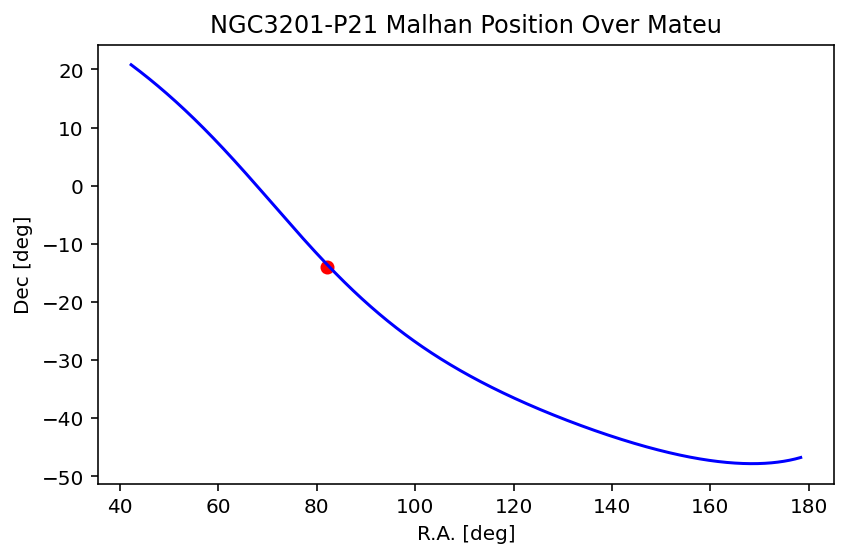

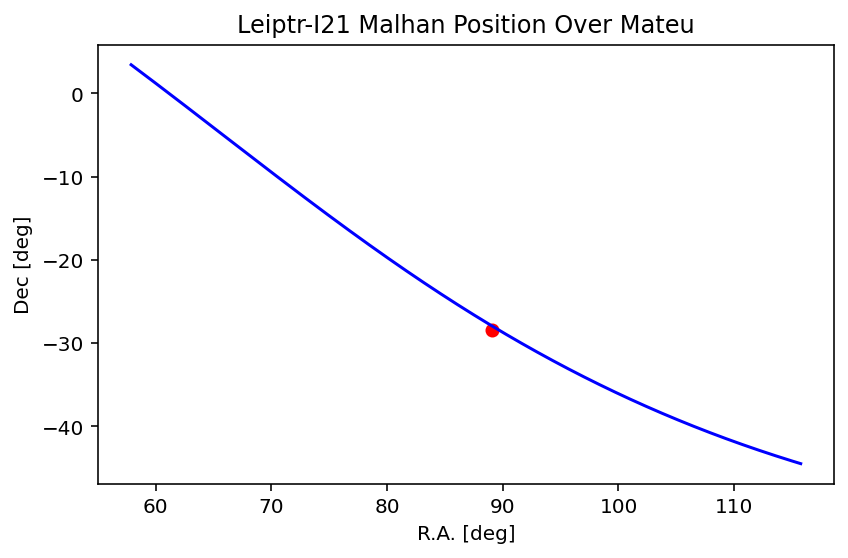

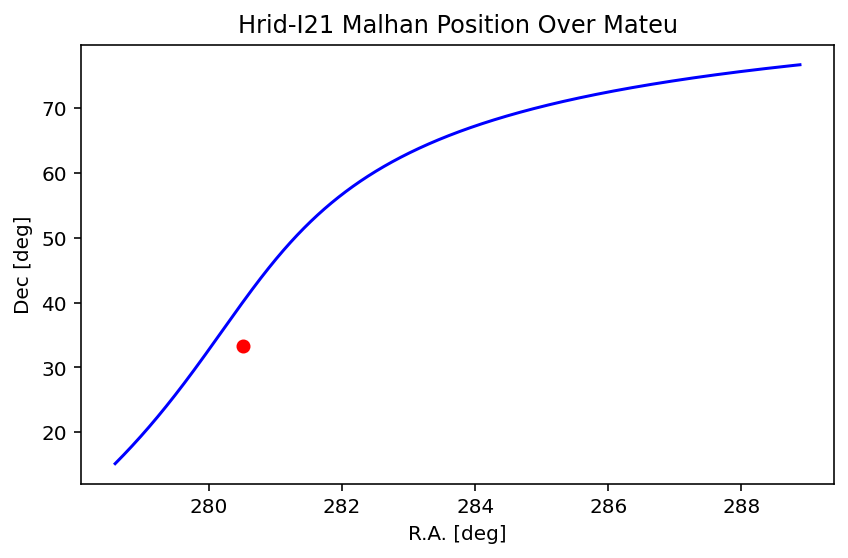

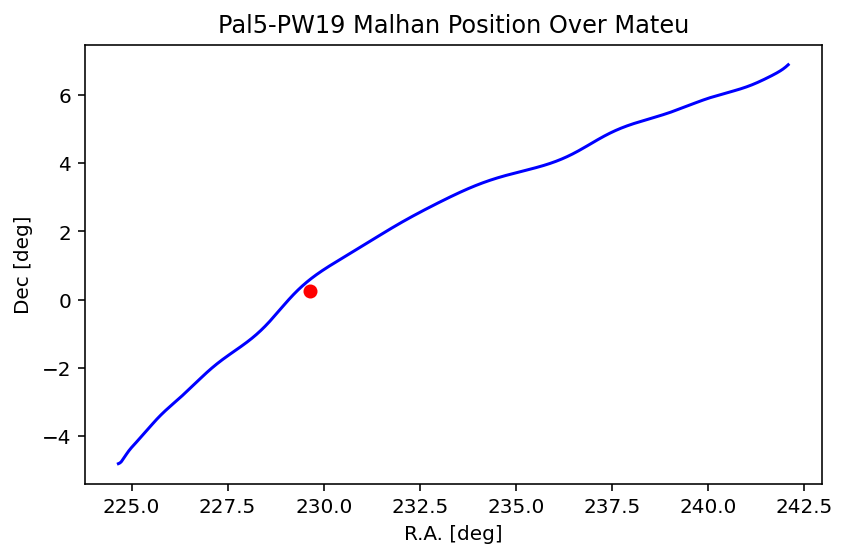

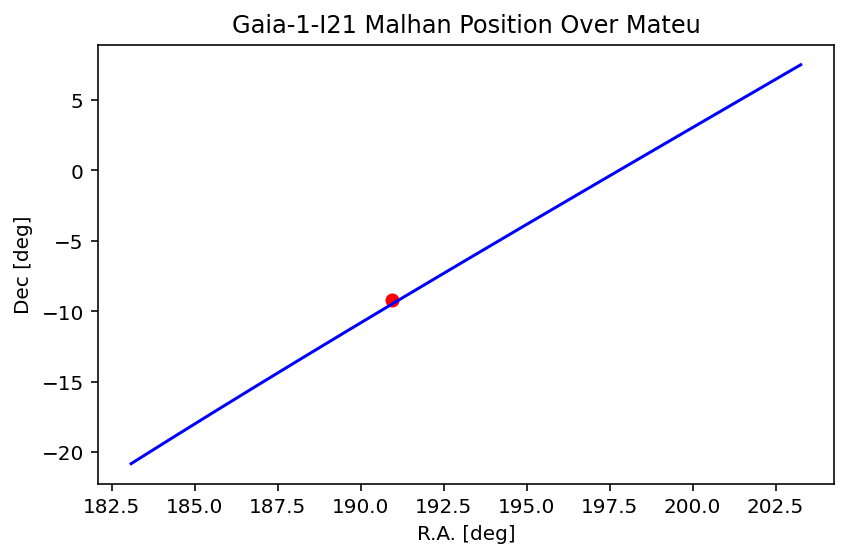

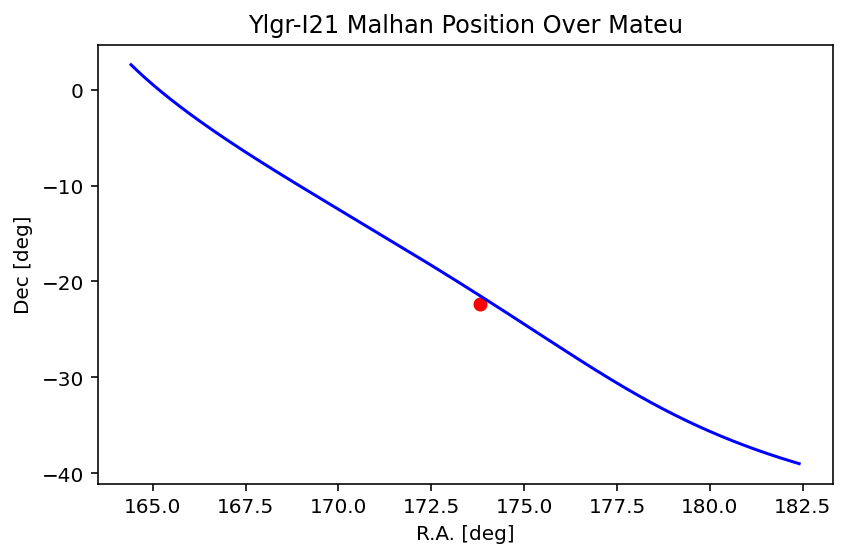

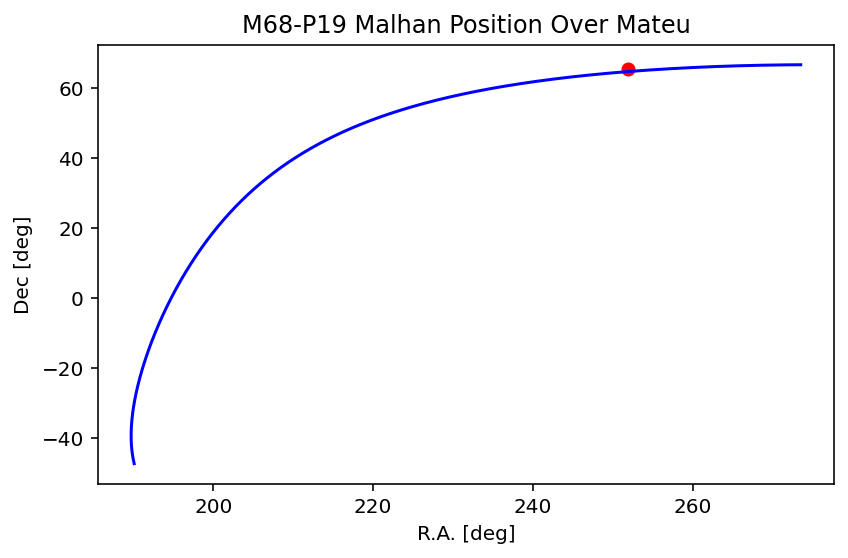

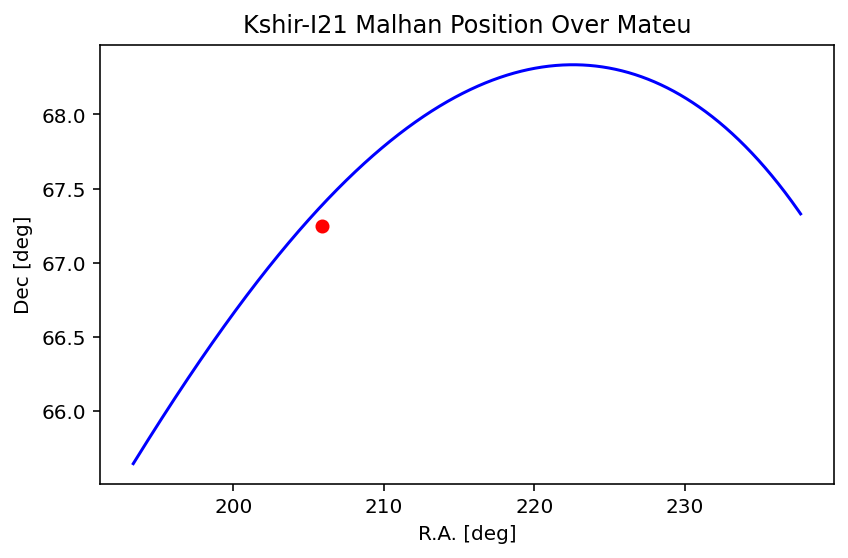

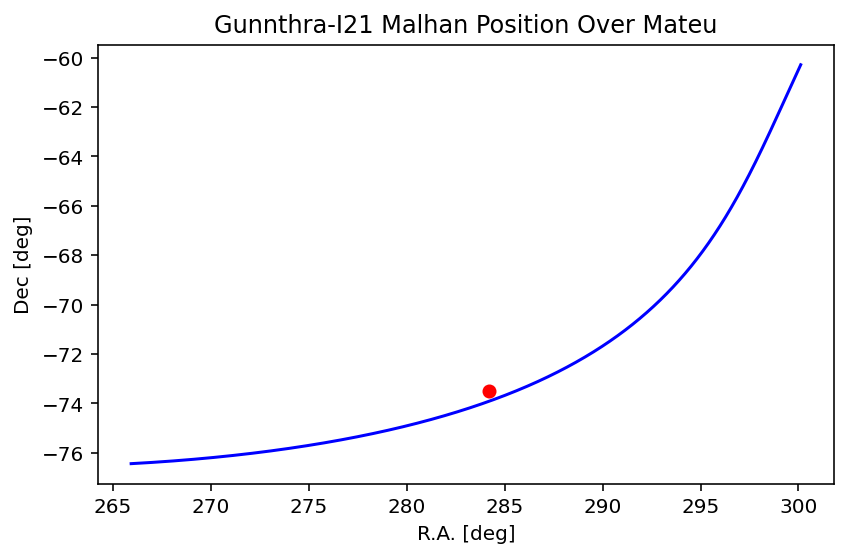

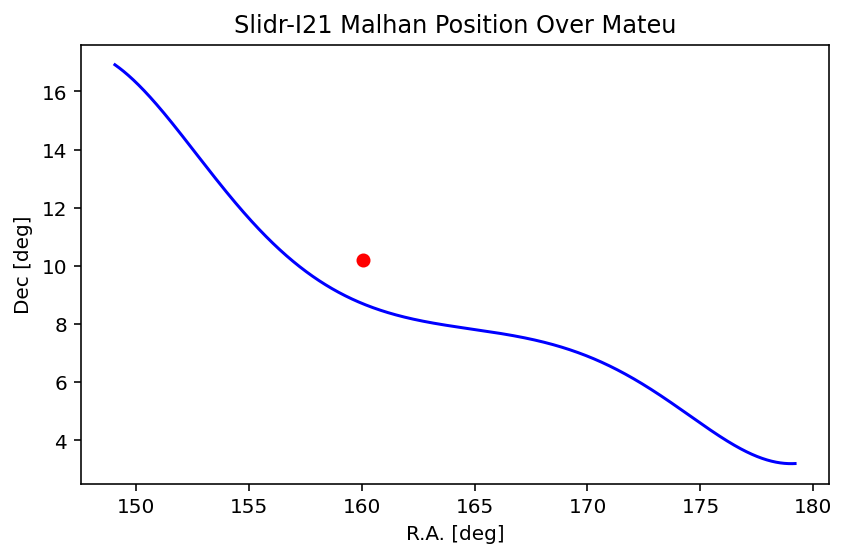

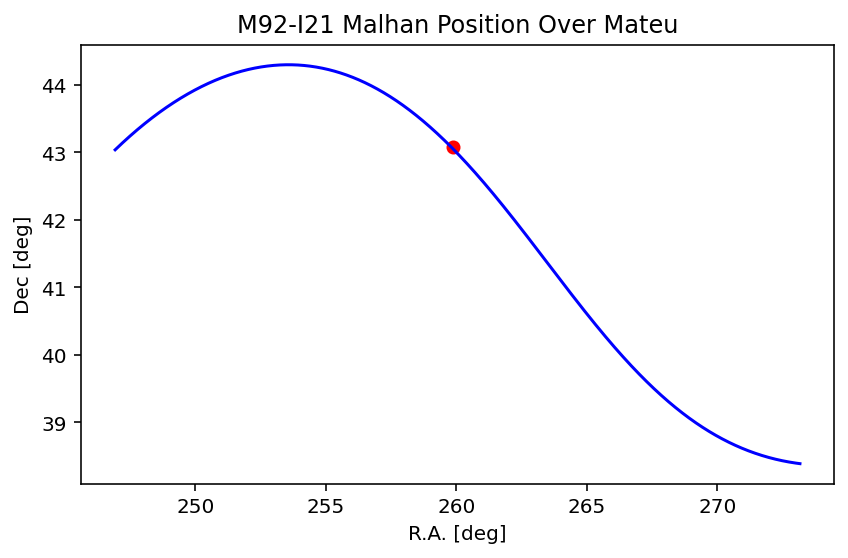

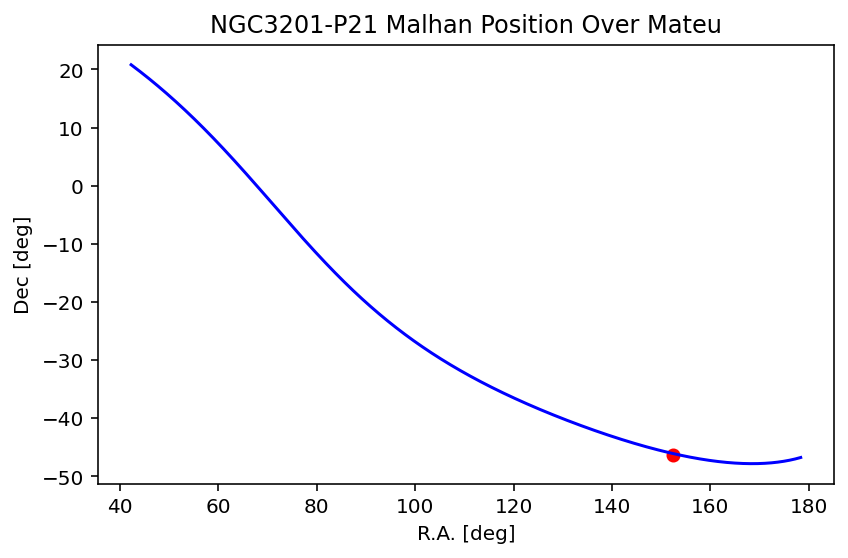

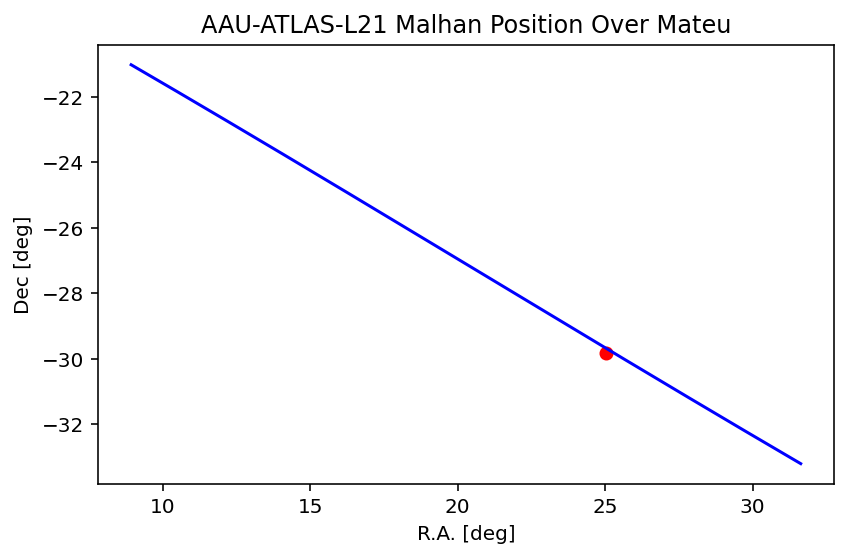

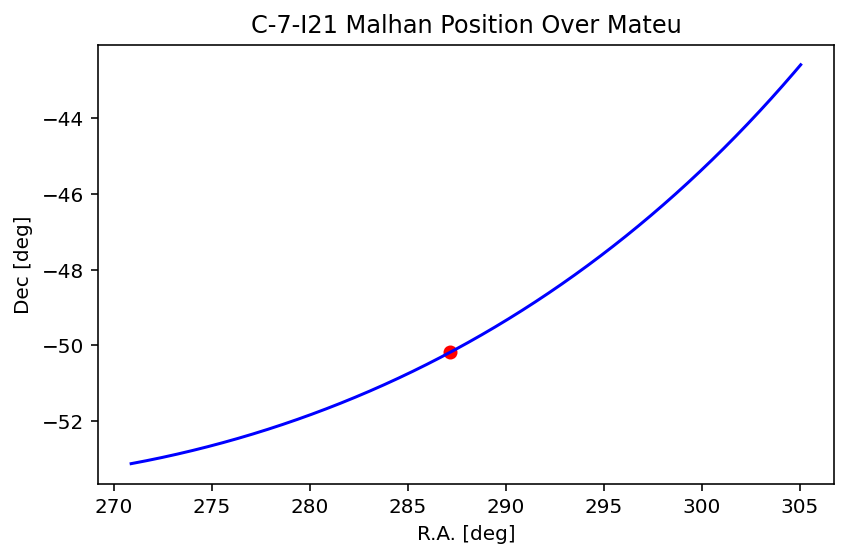

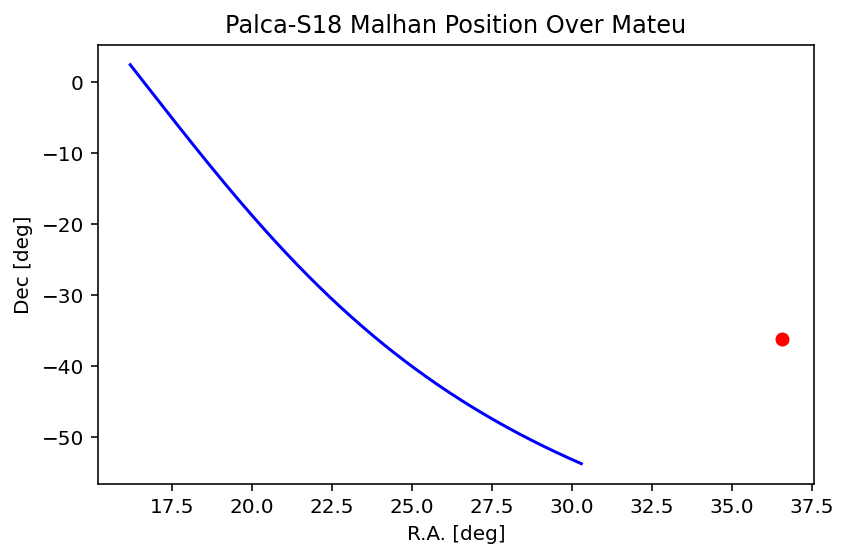

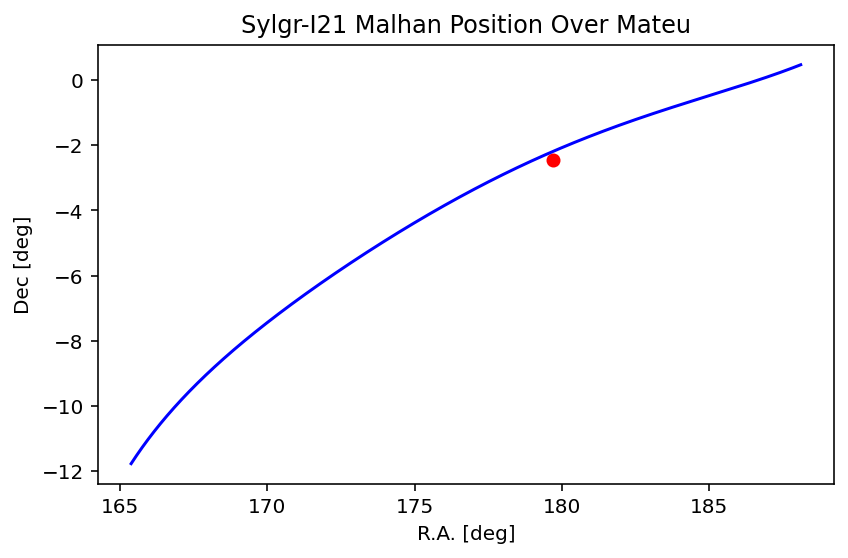

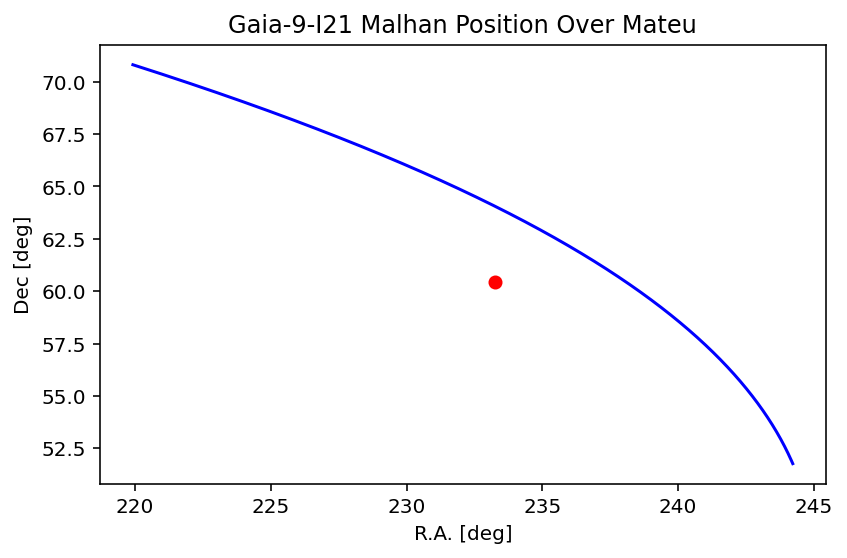

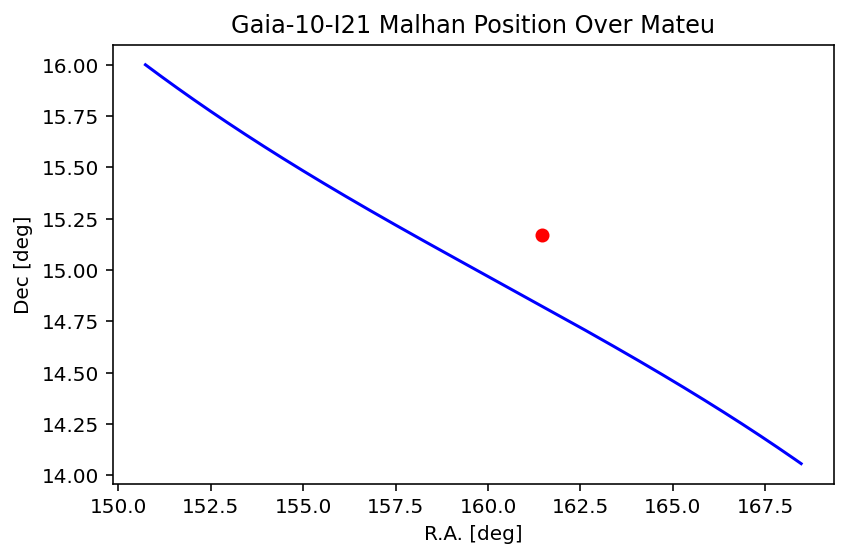

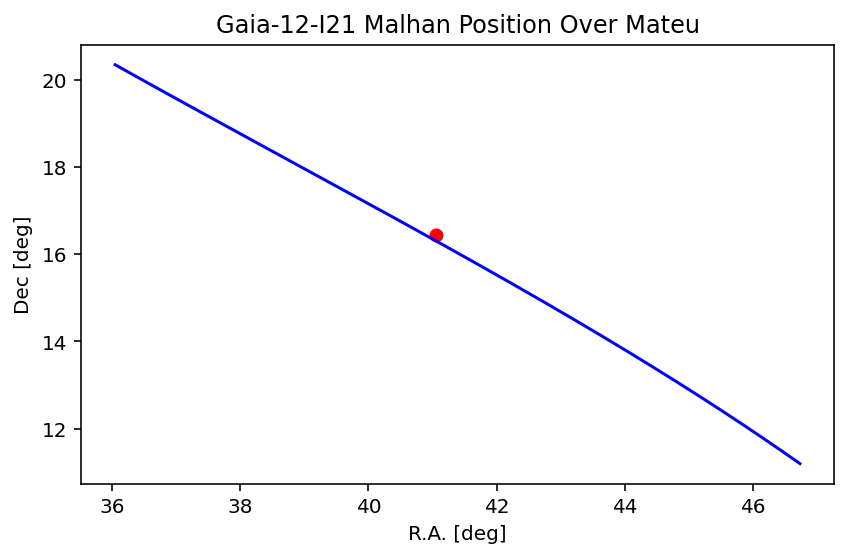

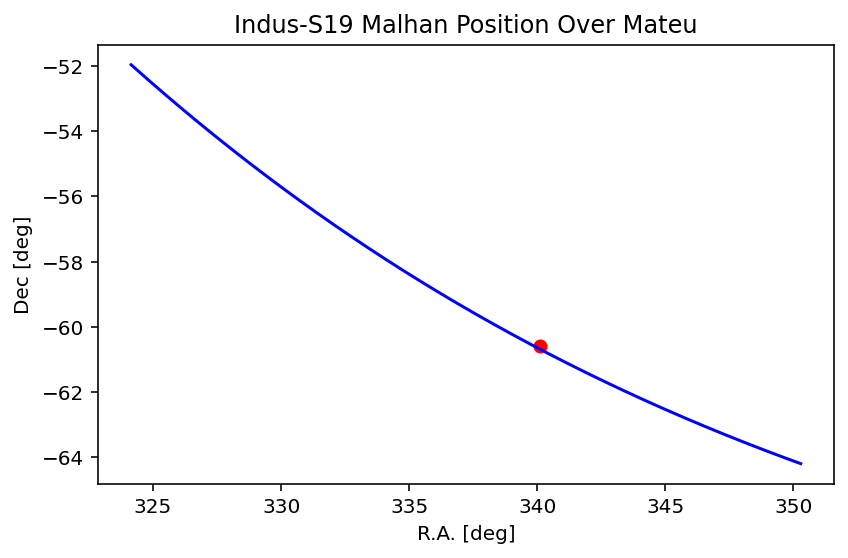

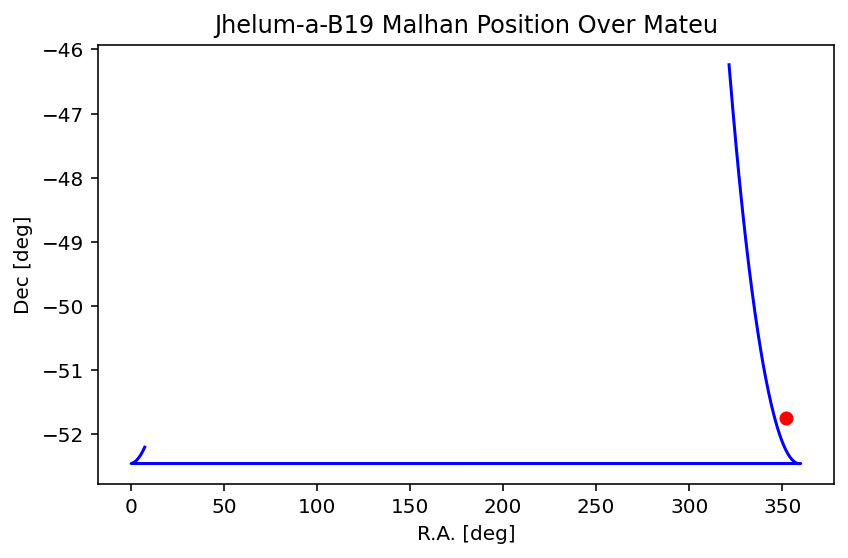

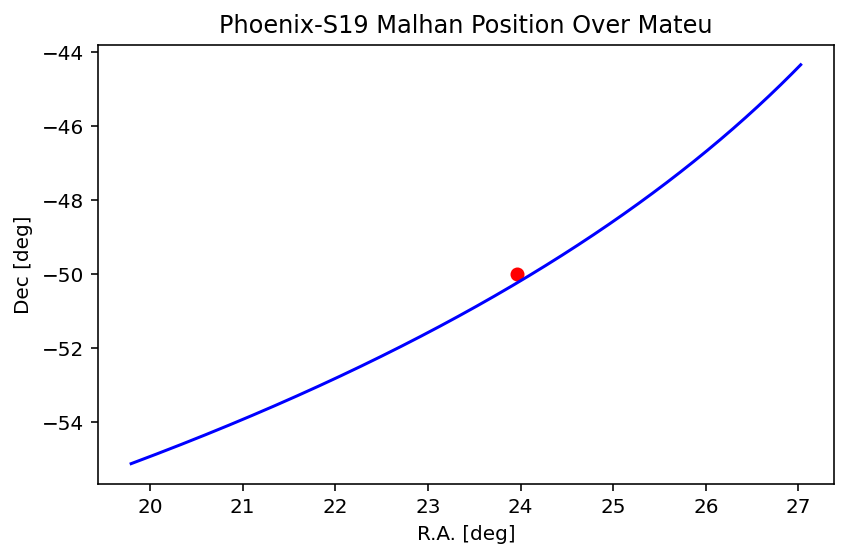

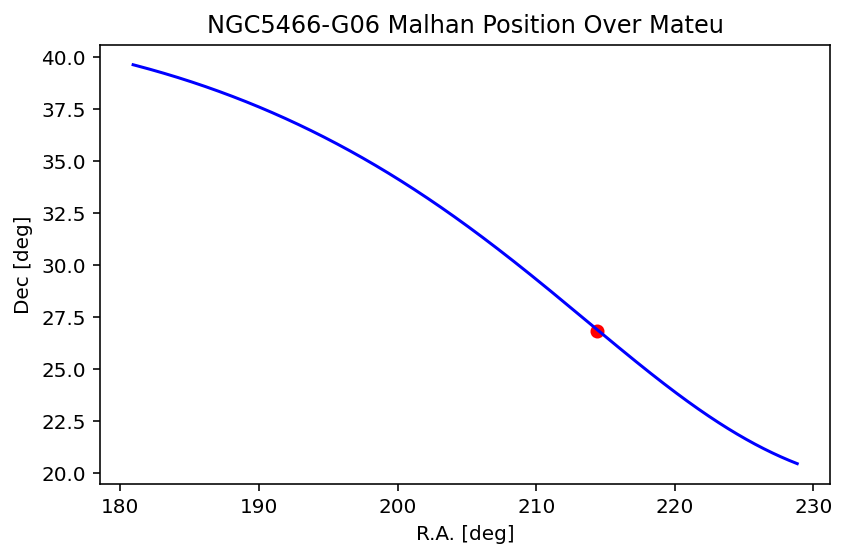

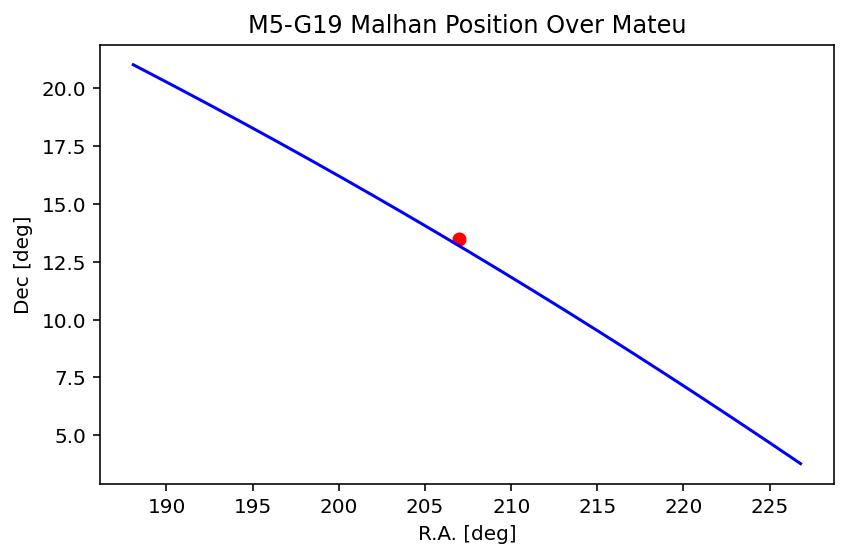

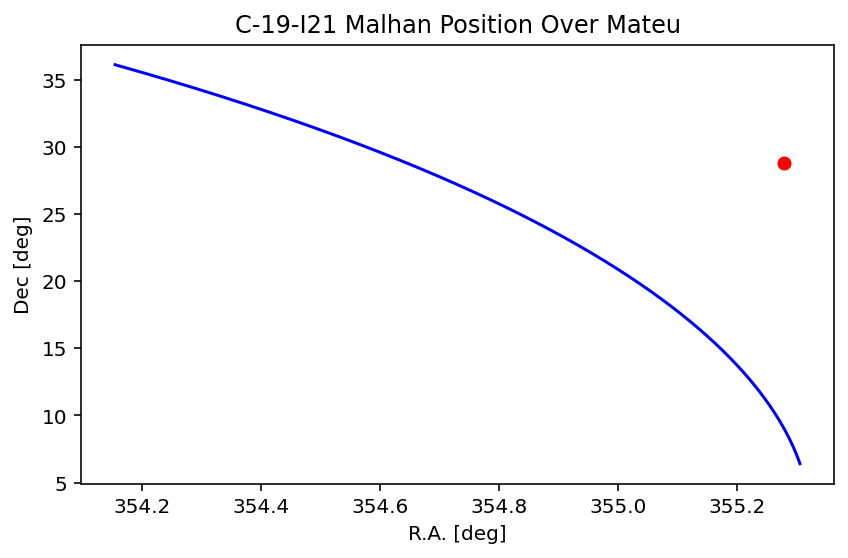

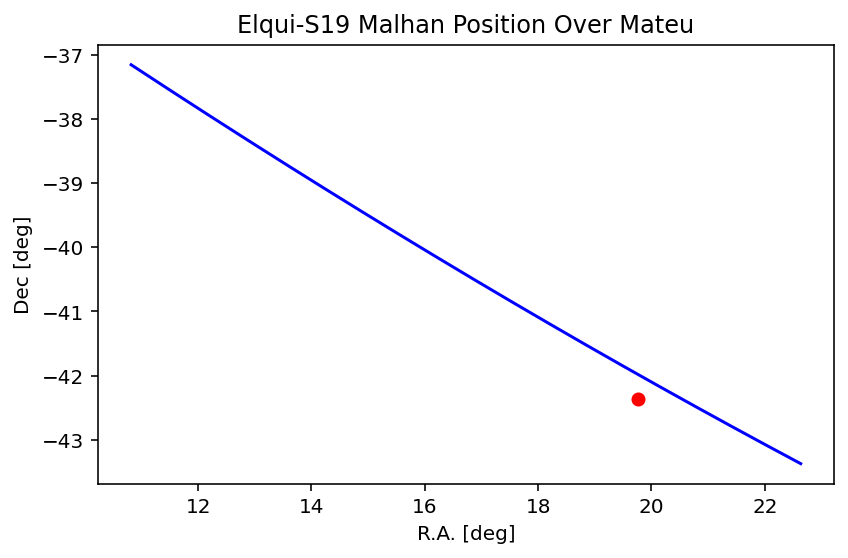

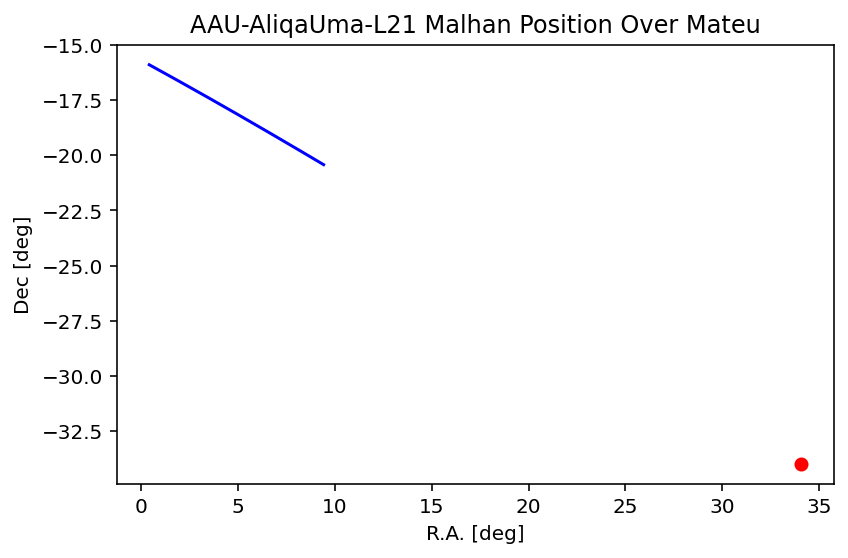

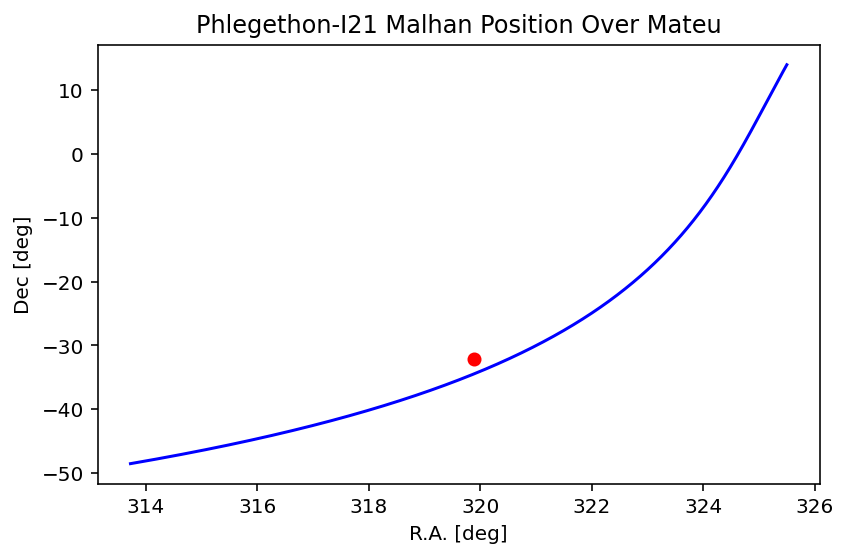

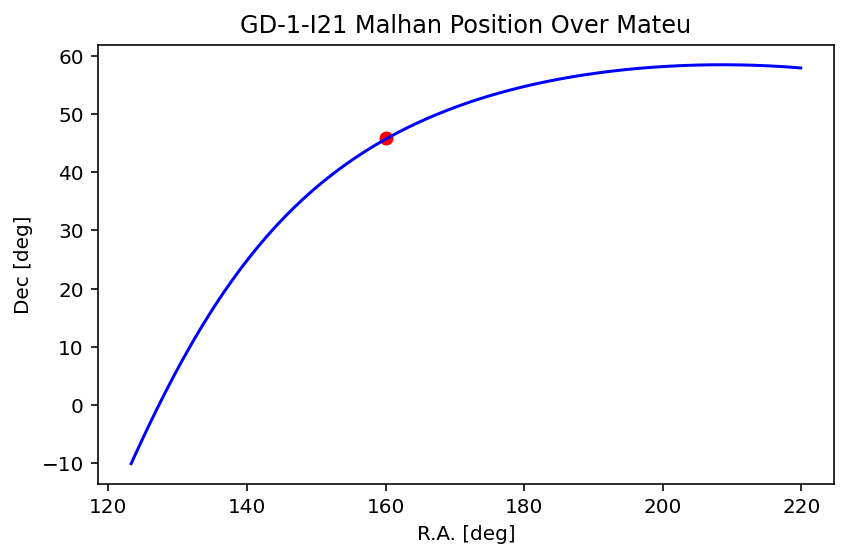

In [18]:
#Initial Point of Malhan (red) vs Stream (Mateu)

# define Galactocentric reference frame
coord.galactocentric_frame_defaults.set('v4.0')
gc_frame = coord.Galactocentric()
#define hamiltonian
ham = gp.Hamiltonian(gp.NFWPotential(m=MW_analog['mvir']/h*u.Msun, 
                                     r_s=(MW_analog['rs'])/h*u.kpc, units=galactic))

for i in range(len(names)):
    if list(names.values())[i] != 'None': #the only one cut off was C_20 because no Mateu Info
        c = coord.SkyCoord(ra=streams.iloc[i][1]*u.deg, dec=streams.iloc[i][2]*u.deg, distance=streams.iloc[i][3]*u.kpc, 
                           pm_ra_cosdec=streams.iloc[i][4]*u.mas/u.yr,pm_dec=streams.iloc[i][5]*u.mas/u.yr, 
                           radial_velocity=streams.iloc[i][6]*u.km/u.s, frame='icrs')
        w0 = gd.PhaseSpacePosition(c.transform_to(gc_frame).cartesian)

        name=list(names.values())[i] #This one corresponds to Gjoll
        plt.figure()
        plt.plot(c.ra.wrap_at(360*u.deg), c.dec, 'ro')
        plt.plot(mwsts[name].track.ra.wrap_at(360*u.deg), mwsts[name].track.dec, 'b-')
        plt.title(list(names.values())[i]+' Malhan Position Over Mateu')
        plt.xlabel('R.A. [deg]')
        plt.ylabel('Dec [deg]')
        #plt.gca().set_aspect('equal')
        plt.tight_layout()

        plt.savefig('Creating_Streams_Steps/Original_Pos/'+name+'_Original_Pos.png', transparent=False, dpi=200)
        
        
        

<ipython-input-19-9267e7c210ea>:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


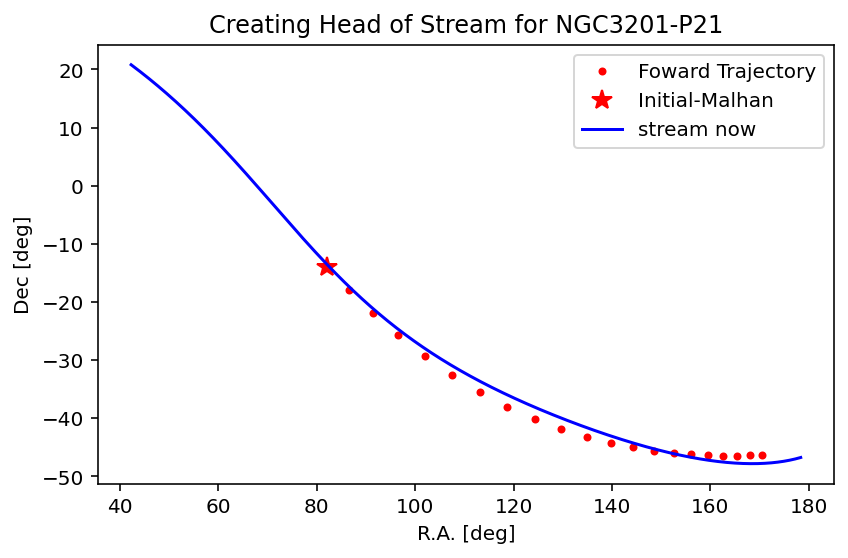

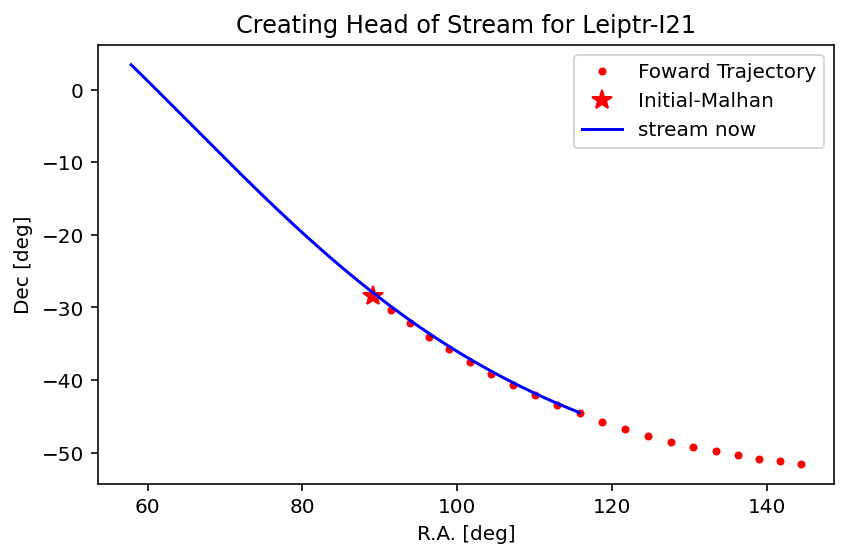

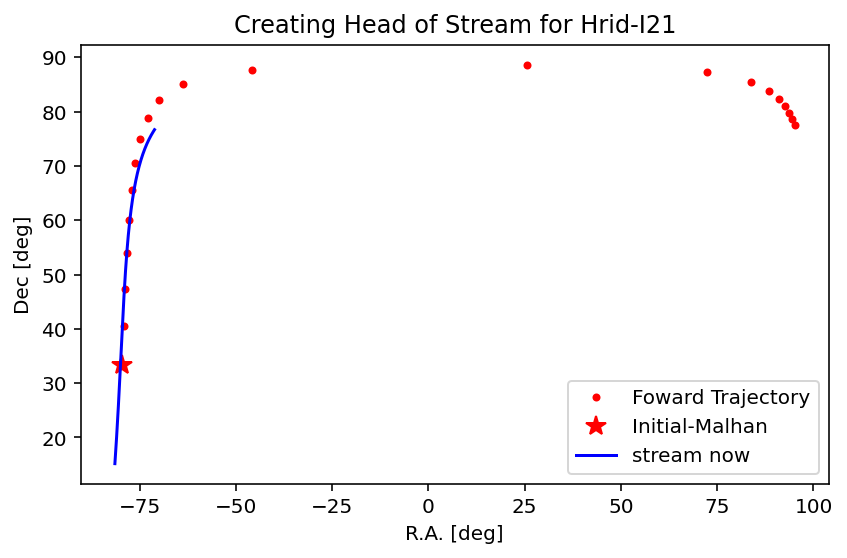

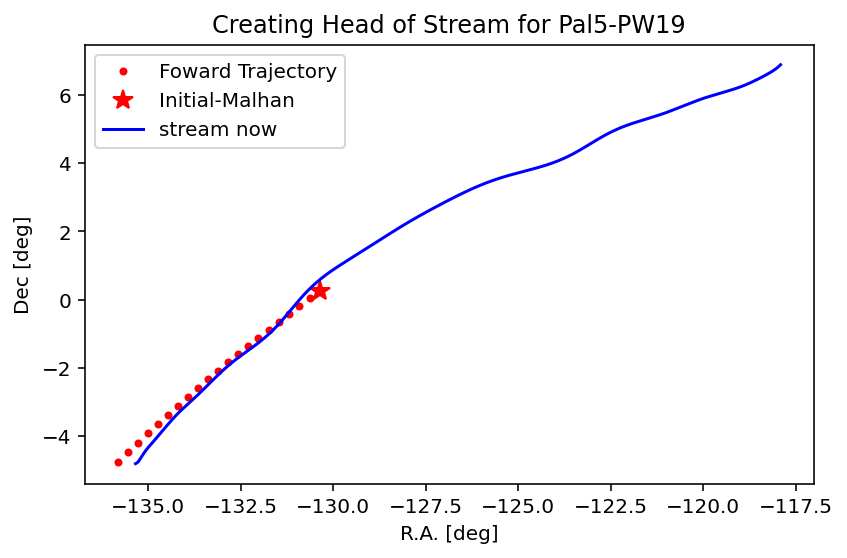

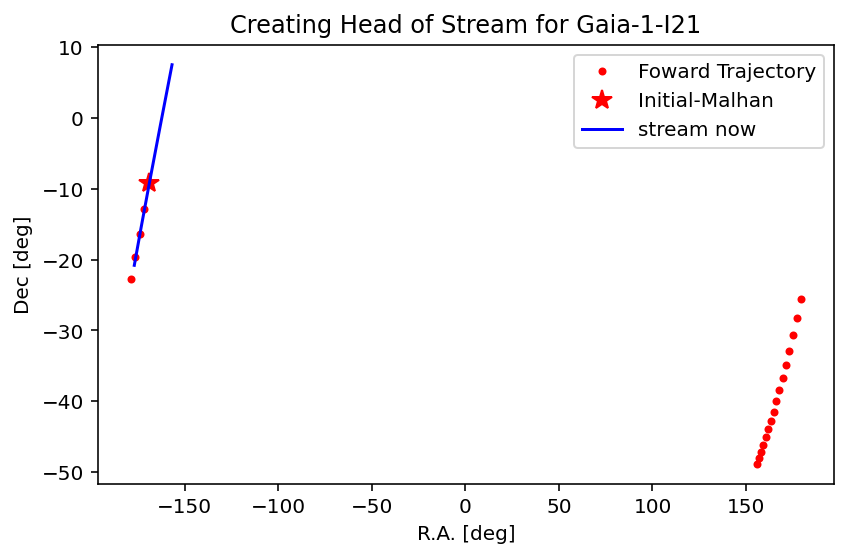

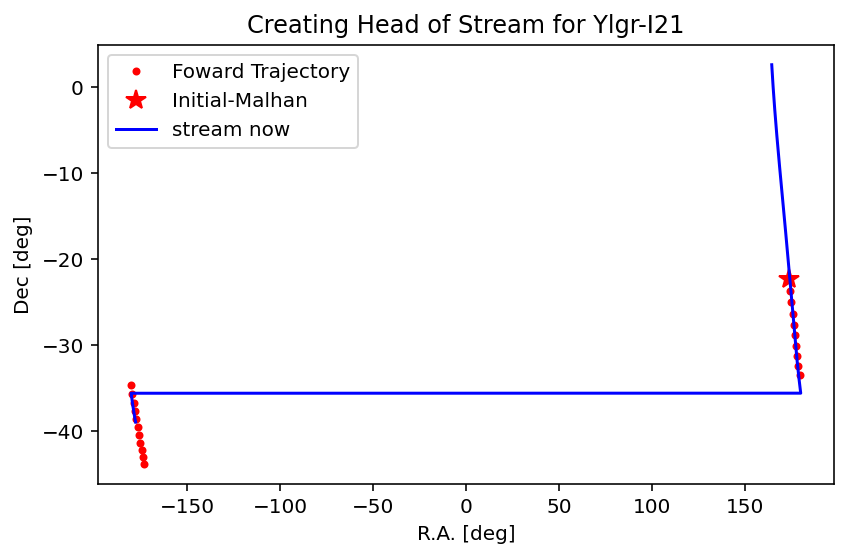

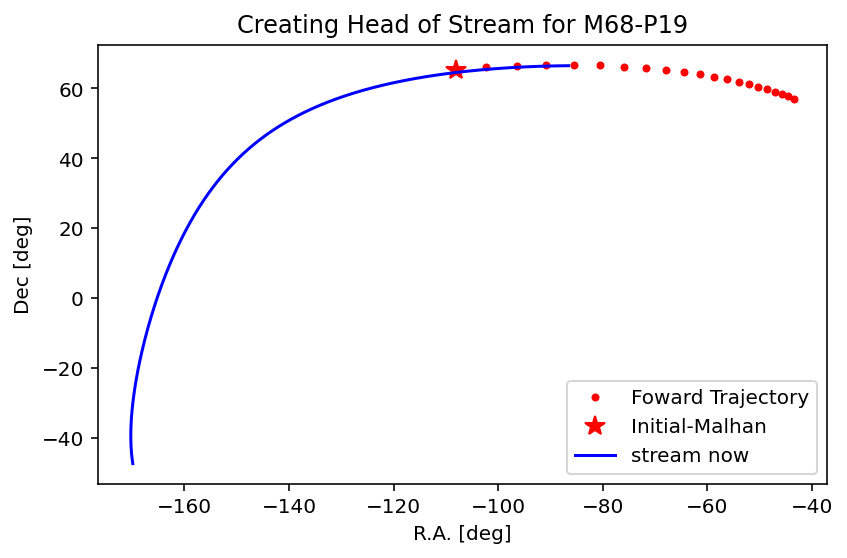

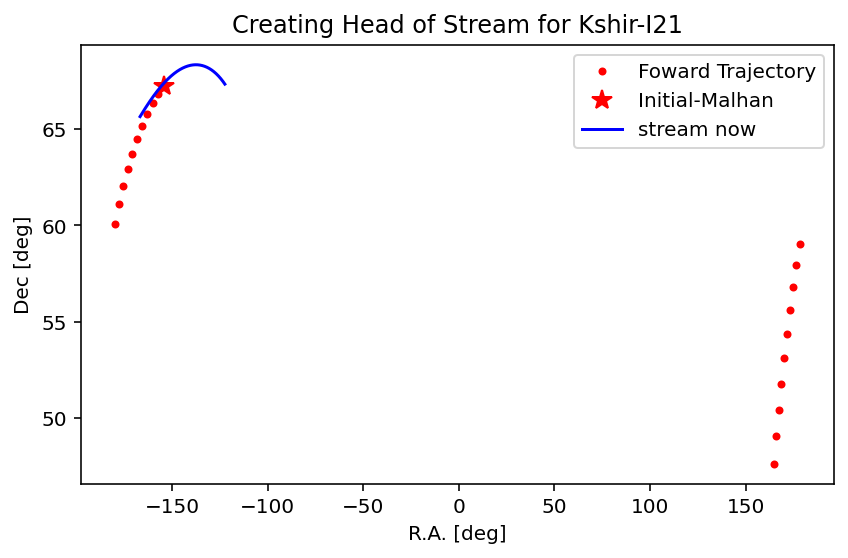

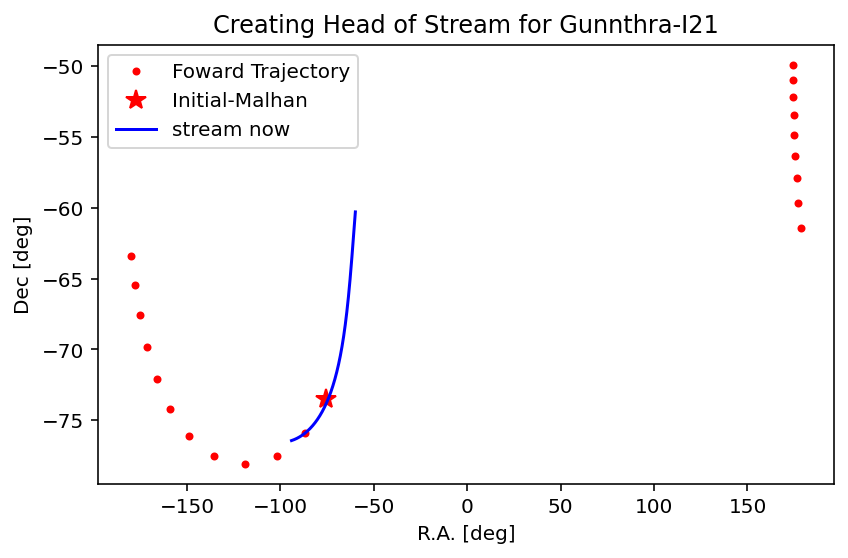

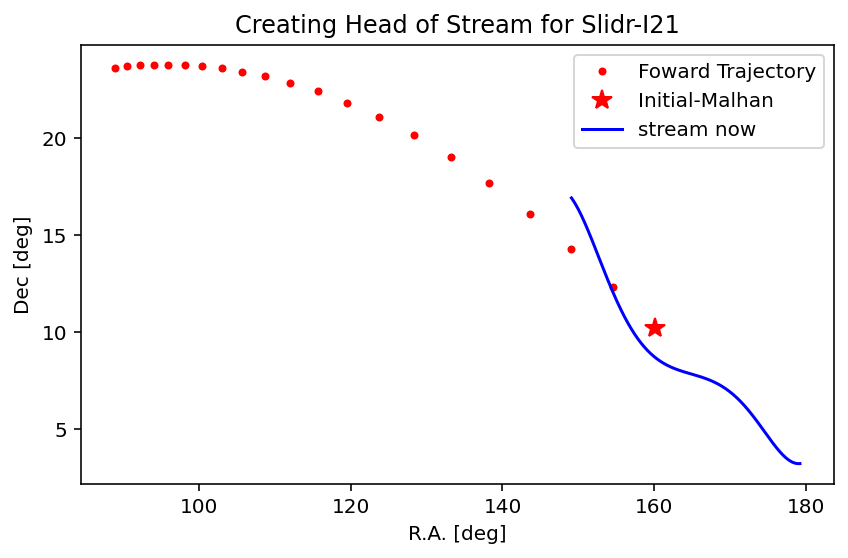

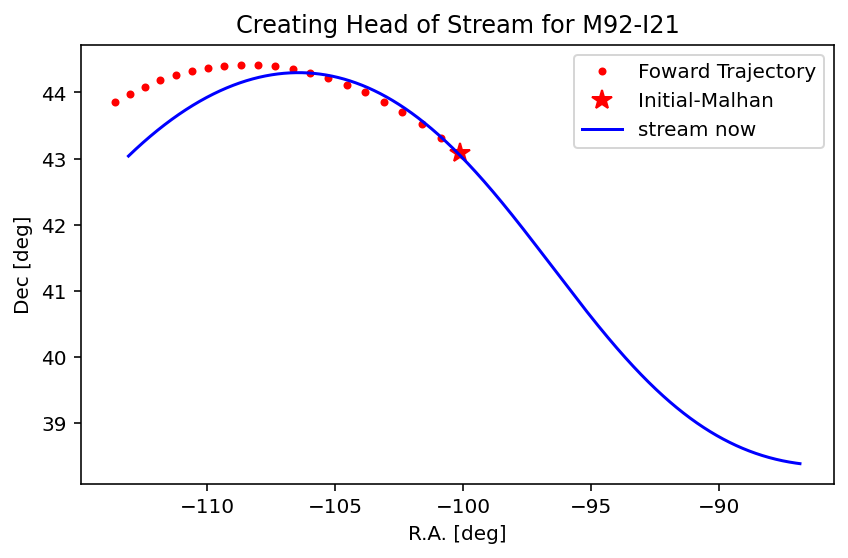

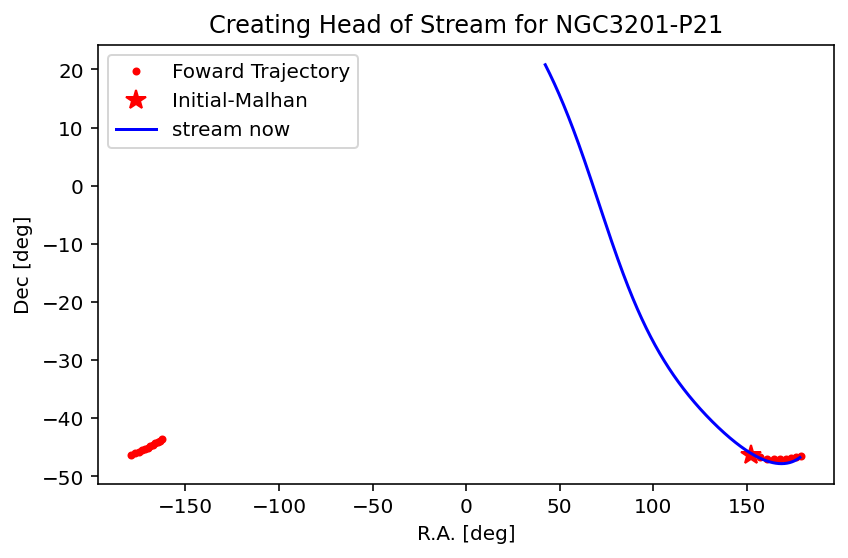

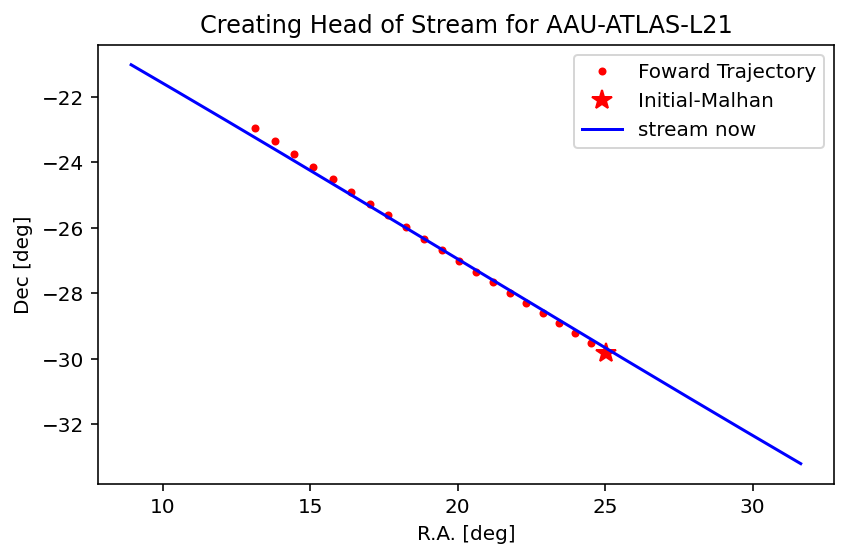

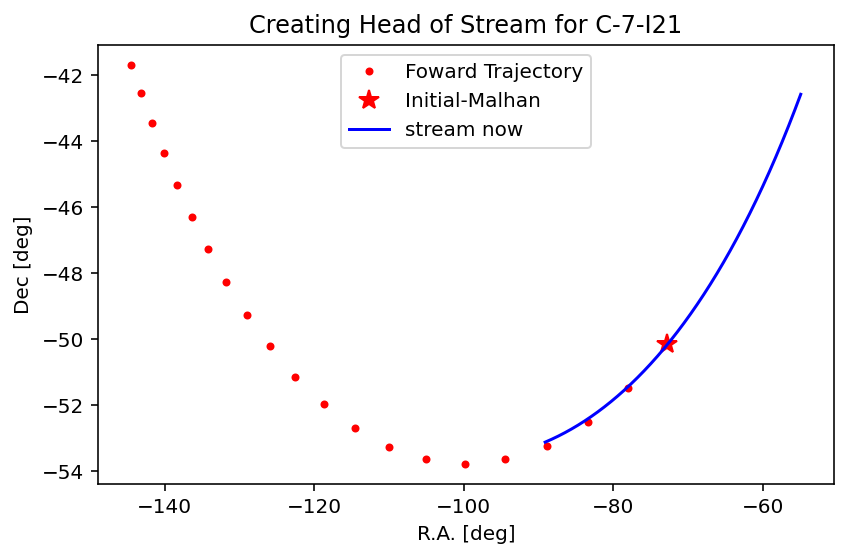

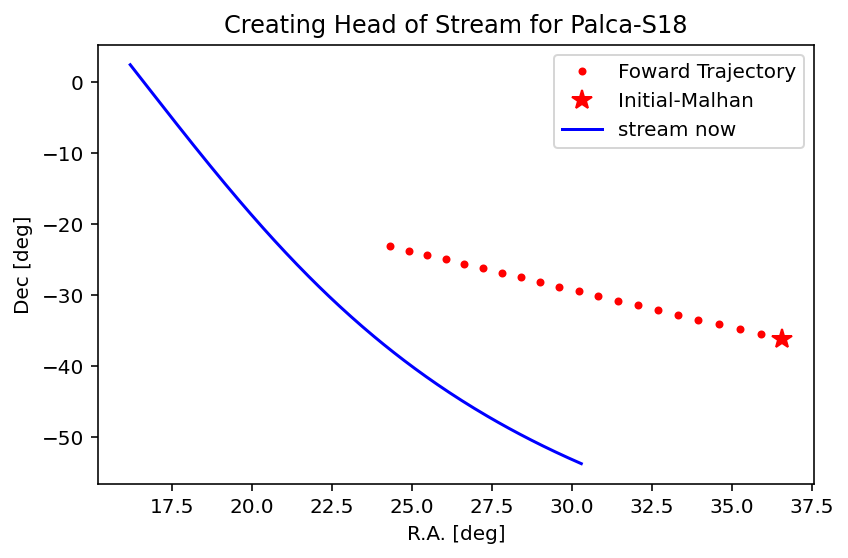

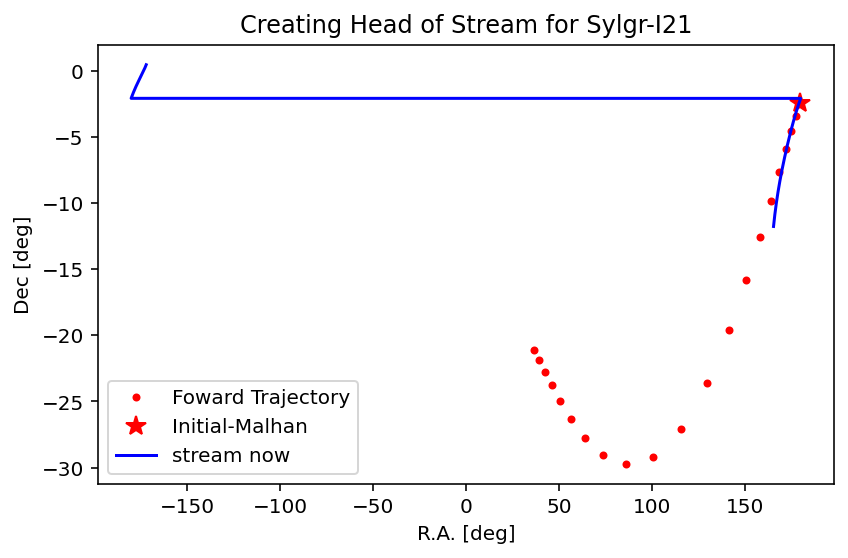

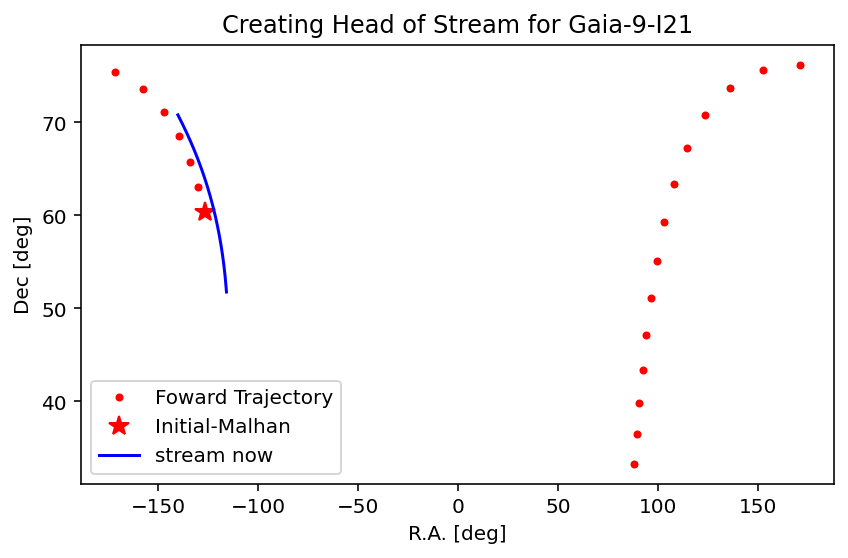

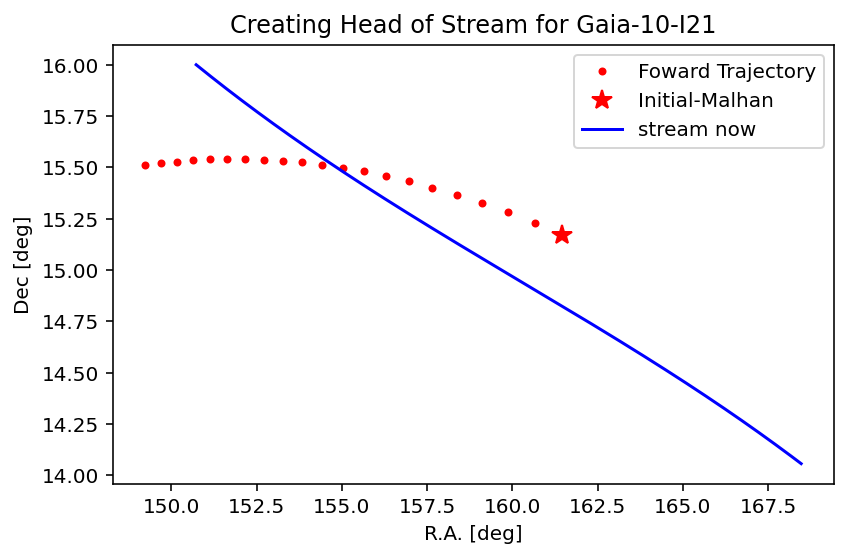

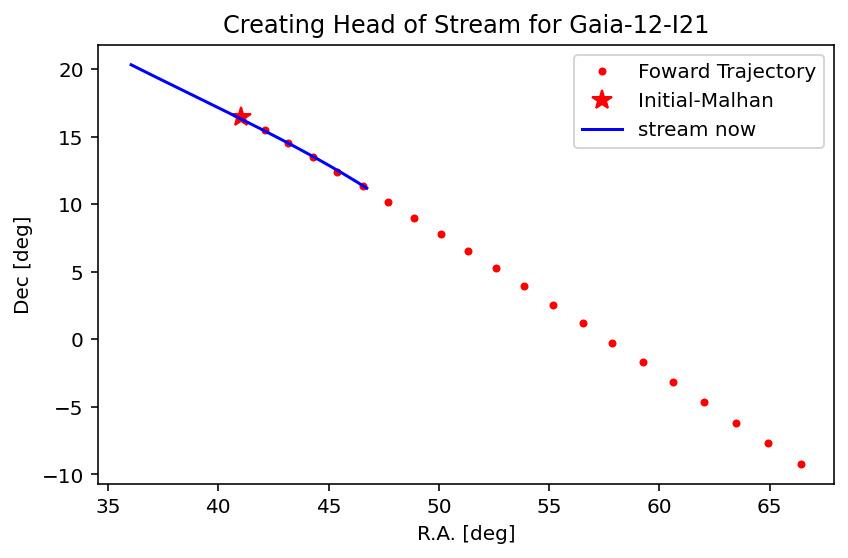

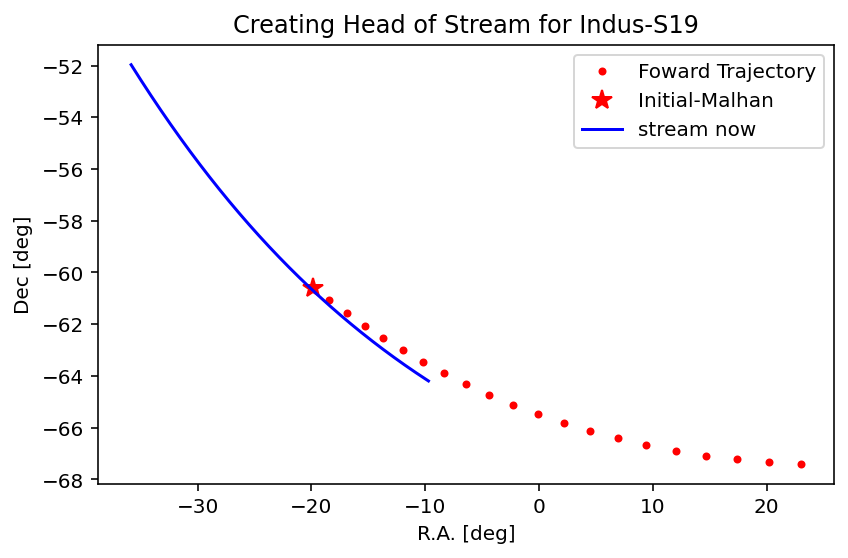

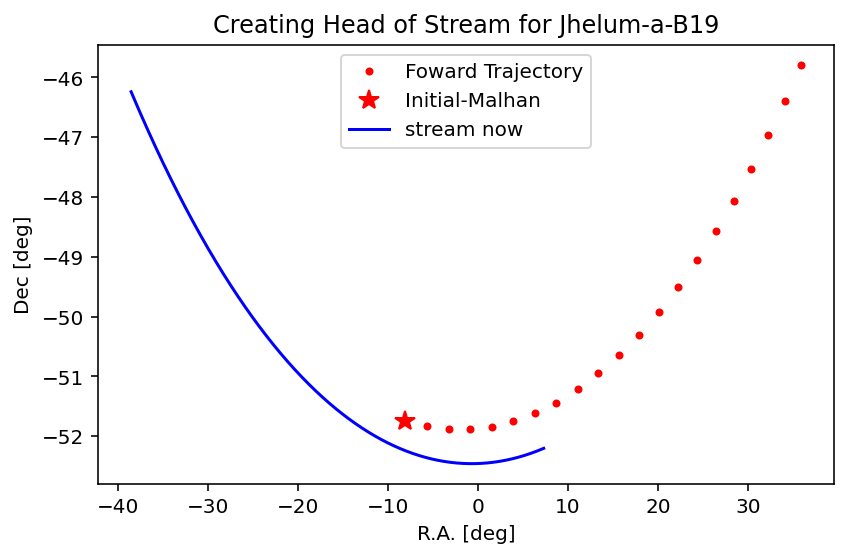

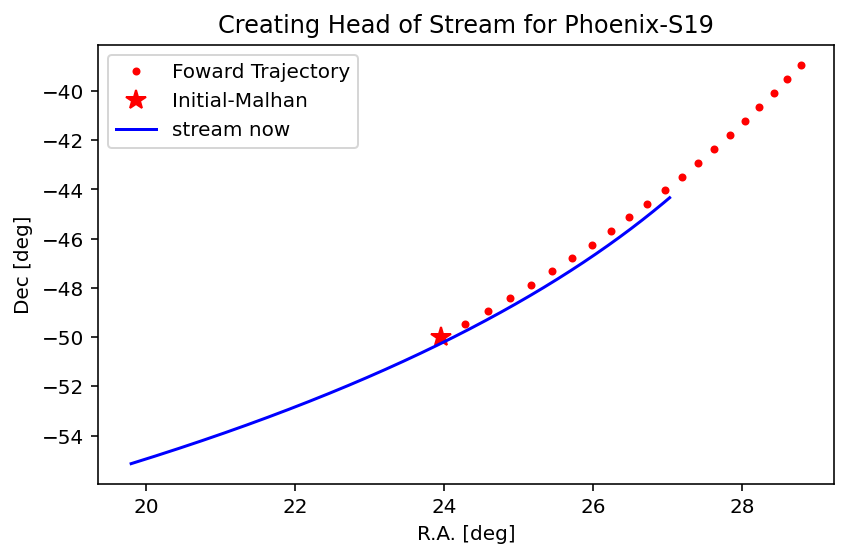

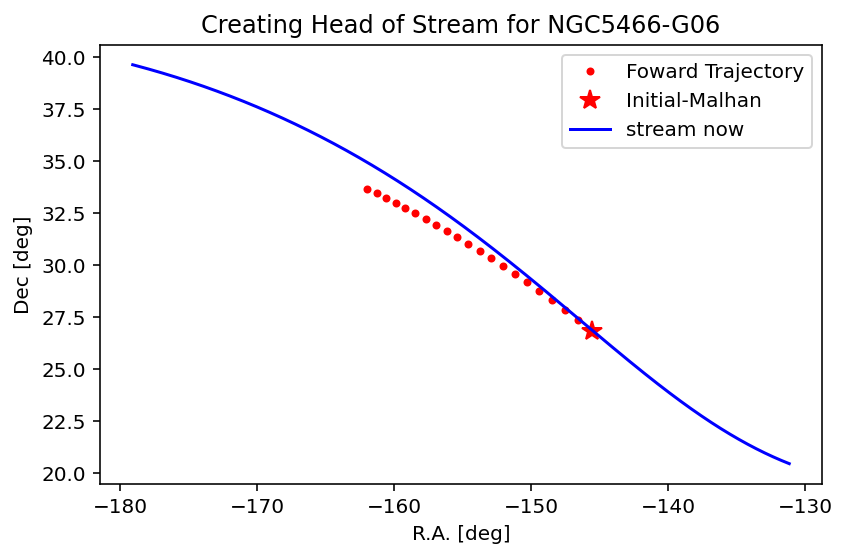

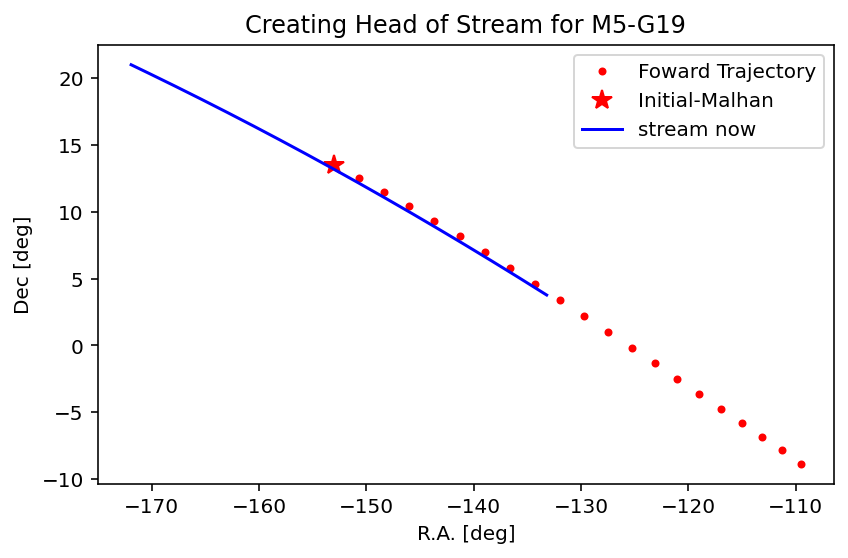

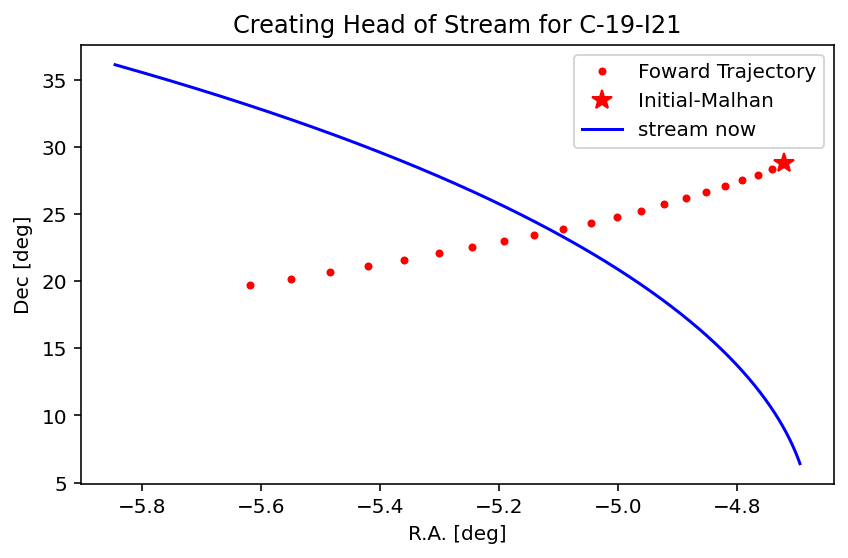

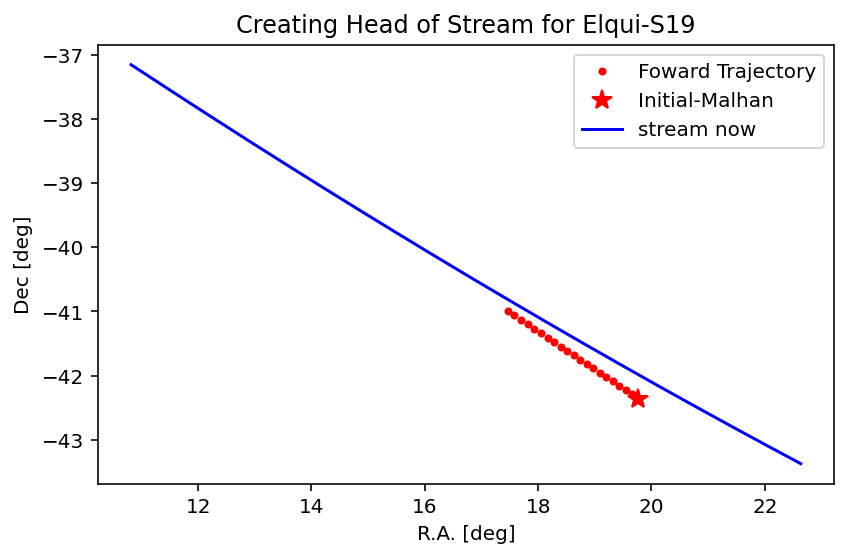

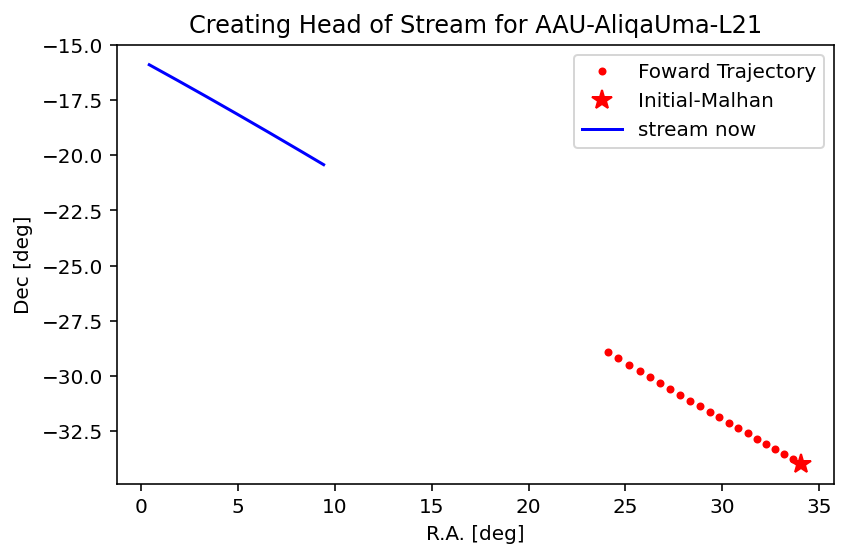

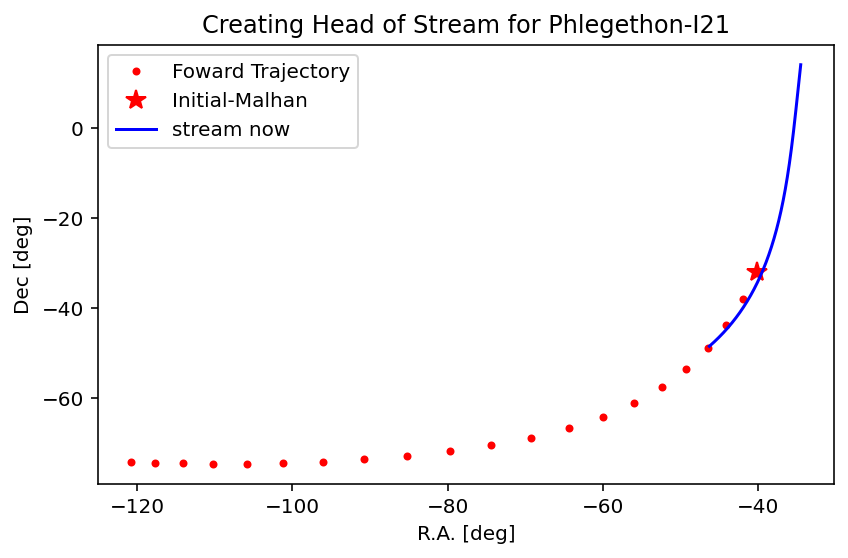

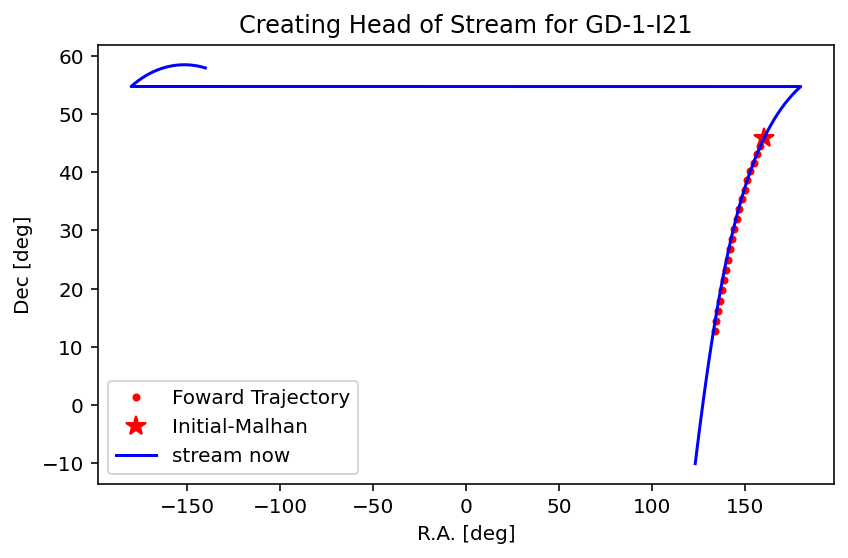

In [19]:
#Figuring out new starting point to represent the stream

# define Galactocentric reference frame
coord.galactocentric_frame_defaults.set('v4.0')
gc_frame = coord.Galactocentric()
#define hamiltonian
ham = gp.Hamiltonian(gp.NFWPotential(m=MW_analog['mvir']/h*u.Msun, 
                                     r_s=(MW_analog['rs'])/h*u.kpc, units=galactic))

for i in range(len(names)):
    if list(names.values())[i] != 'None':
        c = coord.SkyCoord(ra=streams.iloc[i][1]*u.deg, dec=streams.iloc[i][2]*u.deg, distance=streams.iloc[i][3]*u.kpc, 
                           pm_ra_cosdec=streams.iloc[i][4]*u.mas/u.yr,pm_dec=streams.iloc[i][5]*u.mas/u.yr, 
                           radial_velocity=streams.iloc[i][6]*u.km/u.s, frame='icrs')
        w0 = gd.PhaseSpacePosition(c.transform_to(gc_frame).cartesian)

        name=list(names.values())[i] 
        
        plt.figure()
        dt = 1*u.Myr
        Nstep_foward = 20
        orbit_foward = ham.integrate_orbit(w0, dt=dt, n_steps=Nstep_foward)
        orbit_foward_icrs = orbit_foward.to_coord_frame(coord.ICRS())

        plt.plot(orbit_foward_icrs.ra.wrap_at(180*u.deg), orbit_foward_icrs.dec, '.r', label='Foward Trajectory')
        plt.plot(orbit_foward_icrs.ra.wrap_at(180*u.deg)[0], orbit_foward_icrs.dec[0], '*r', label='Initial-Malhan', ms=10)
        plt.plot(mwsts[name].track.ra.wrap_at(180*u.deg), mwsts[name].track.dec, 'b-', label='stream now')
        plt.legend(loc='best')
        plt.title('Creating Head of Stream for '+name)
        plt.xlabel('R.A. [deg]')
        plt.ylabel('Dec [deg]')
        plt.tight_layout()
        plt.savefig('Creating_Streams_Steps/New_Initial_Pos/'+name+'_New_Initial_Pos.png', transparent=False, dpi=200)


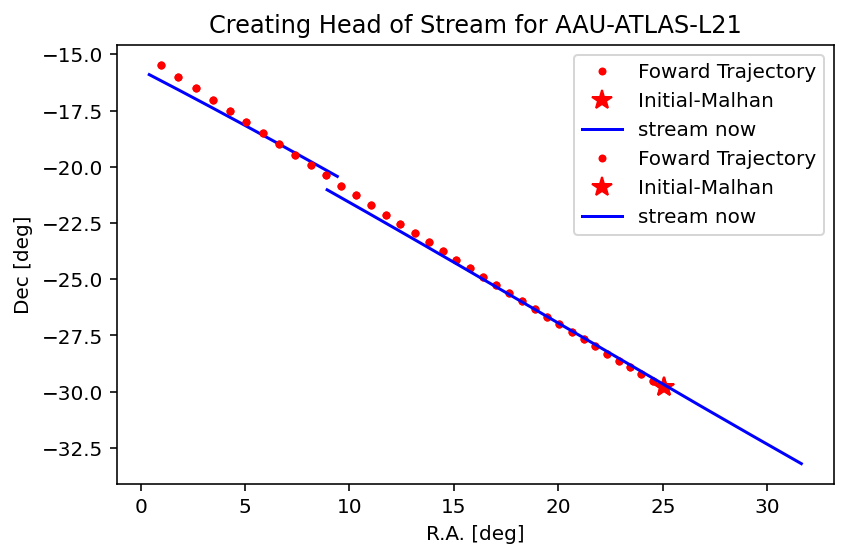

In [20]:
#Combining AliquaUma and Atlas because they are the same stream
#Atlas is 12th index

names_aliqua_atlas = dict(AliqaUma= 'AAU-AliqaUma-L21',Atlas= 'AAU-ATLAS-L21')

coord.galactocentric_frame_defaults.set('v4.0')
gc_frame = coord.Galactocentric()
#define hamiltonian
ham = gp.Hamiltonian(gp.NFWPotential(m=MW_analog['mvir']/h*u.Msun, 
                                     r_s=(MW_analog['rs'])/h*u.kpc, units=galactic))

for i in range(len(names_aliqua_atlas)):
    #if list(names.values())[i] != 'None':
    #Get the Correct Index 
    #Start at the end of Atlas
    c = coord.SkyCoord(ra=streams.iloc[12][1]*u.deg, dec=streams.iloc[12][2]*u.deg, distance=streams.iloc[12][3]*u.kpc, 
                       pm_ra_cosdec=streams.iloc[12][4]*u.mas/u.yr,pm_dec=streams.iloc[12][5]*u.mas/u.yr, 
                       radial_velocity=streams.iloc[12][6]*u.km/u.s, frame='icrs')
    w0 = gd.PhaseSpacePosition(c.transform_to(gc_frame).cartesian)

    name=list(names_aliqua_atlas.values())[i] 

    #plt.figure()
    dt = 1*u.Myr
    Nstep_foward = 36
    orbit_foward = ham.integrate_orbit(w0, dt=dt, n_steps=Nstep_foward)
    orbit_foward_icrs = orbit_foward.to_coord_frame(coord.ICRS())

    plt.plot(orbit_foward_icrs.ra.wrap_at(180*u.deg), orbit_foward_icrs.dec, '.r', label='Foward Trajectory')
    plt.plot(orbit_foward_icrs.ra.wrap_at(180*u.deg)[0], orbit_foward_icrs.dec[0], '*r', label='Initial-Malhan', ms=10)
    plt.plot(mwsts[name].track.ra.wrap_at(180*u.deg), mwsts[name].track.dec, 'b-', label='stream now')
    plt.legend(loc='best')

    plt.title('Creating Head of Stream for '+name)
    plt.xlabel('R.A. [deg]')
    plt.ylabel('Dec [deg]')
    plt.tight_layout()

        

In [18]:
#Now we have all the information on the number of steps FOWARD 
Nstep_foward_dict = dict(Gjoll=20,Leiptr=10,
Hrid=8, Pal5=19, 
Gaia_1=3, Ylgr=12, 
Fjorm=4, Kshir=3, 
Gunnthra=1, Slidr=2, 
M92=20, NGC_3201=8, 
Atlas=36, C_7=3, 
Palca='Unknown', Sylgr=5, 
Gaia_9=4, Gaia_10=17, 
Gaia_12=5, Indus=7, 
Jhelum=6, Phoenix=11,
NGC5466=50, M5=8, 
C_20='None', C_19='Unknown', 
Elqui=70, AliqaUma='Unknown', #getting rid of AliquaUma
Phlegethon=3, GD_1=35)

<ipython-input-19-1183f6dd9bf6>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


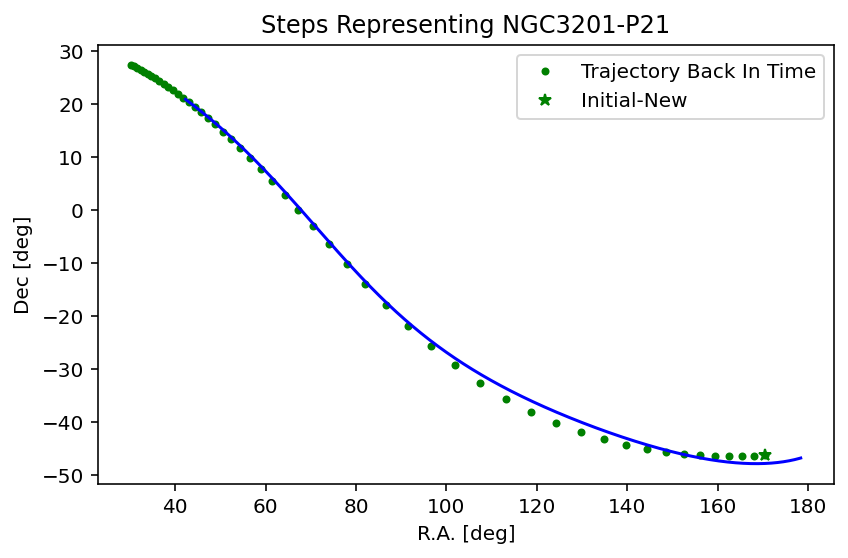

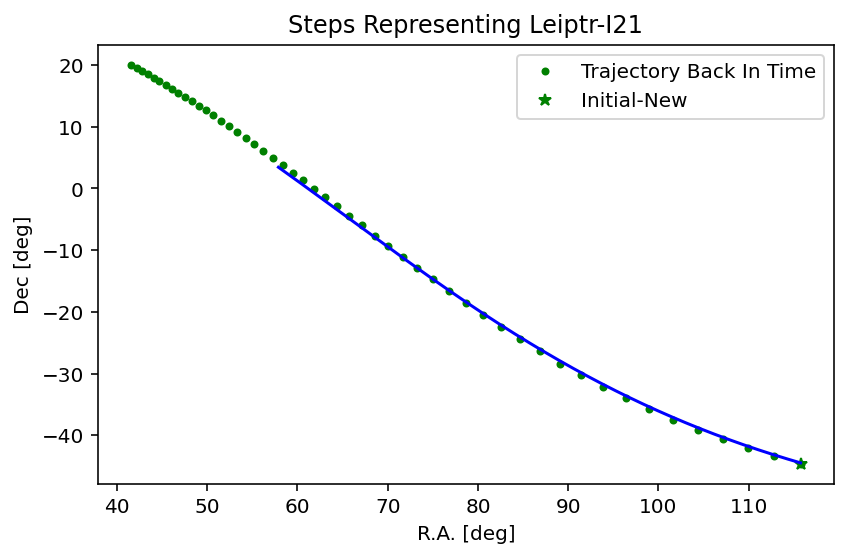

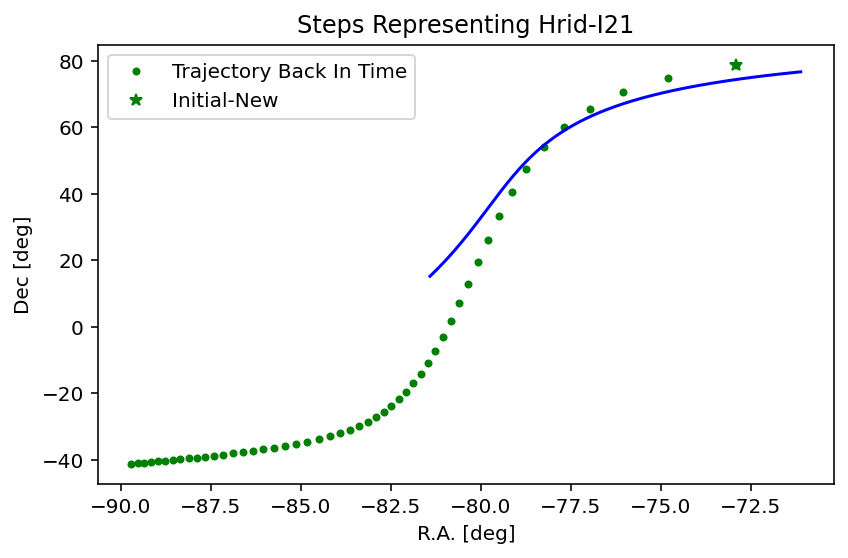

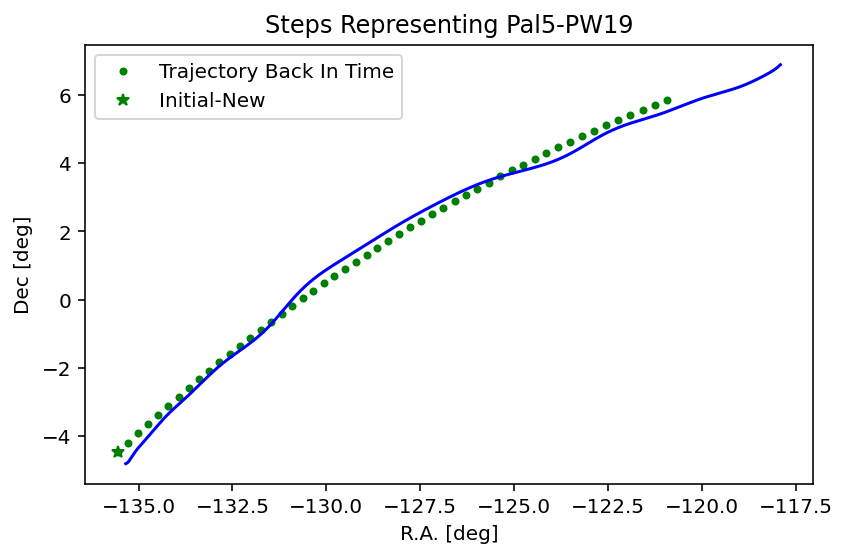

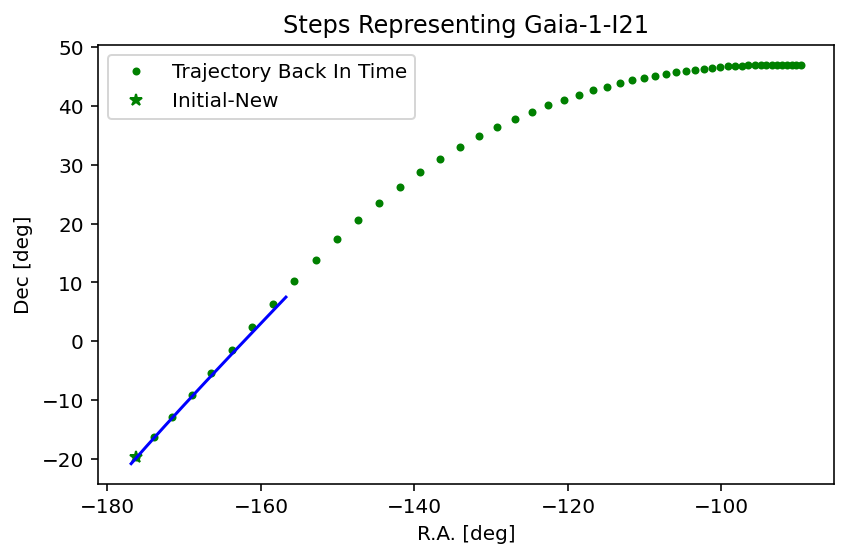

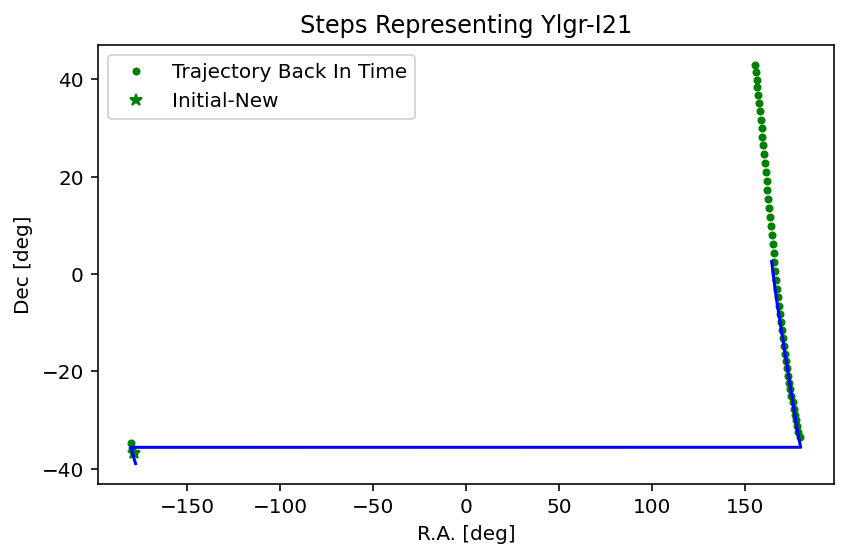

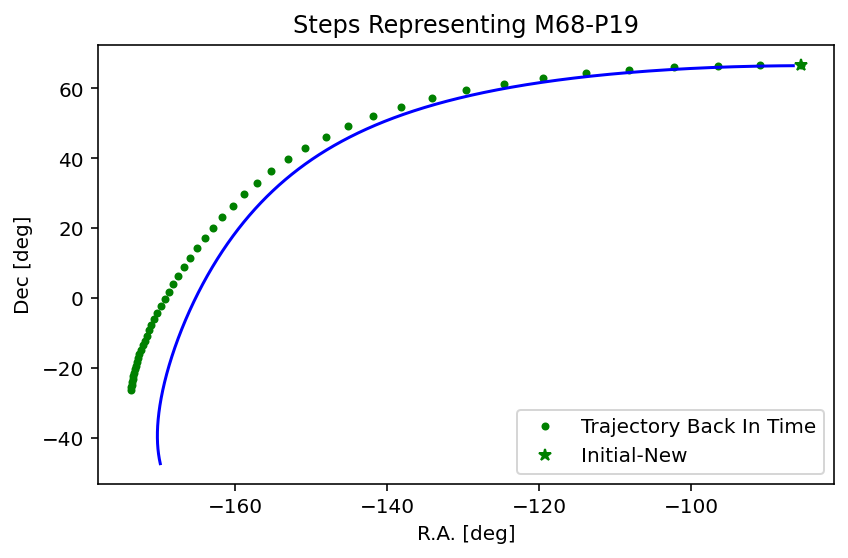

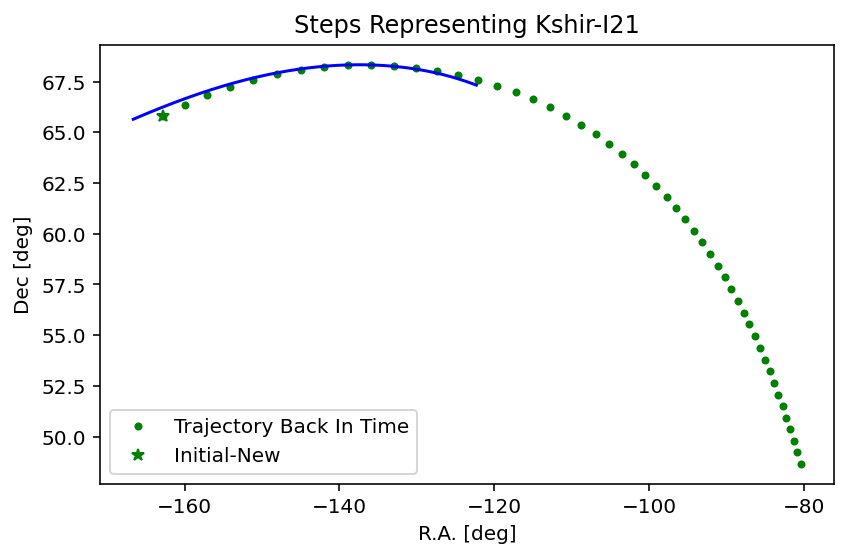

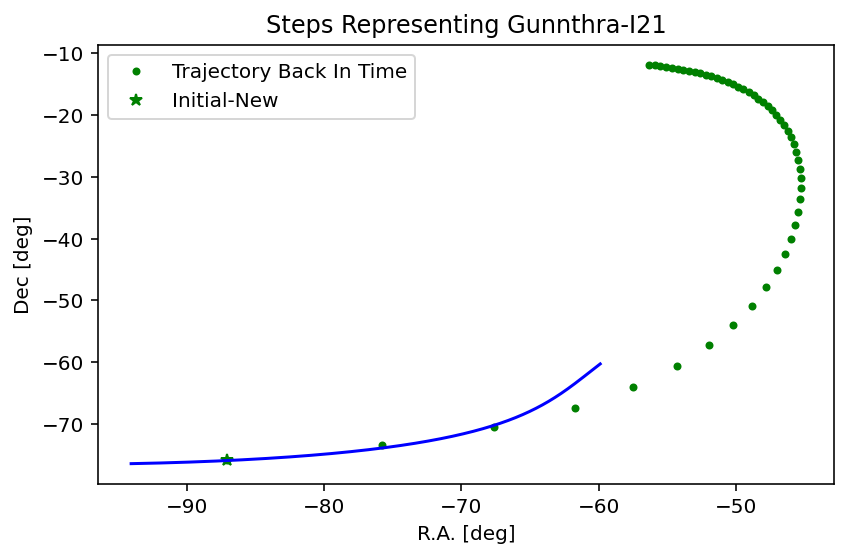

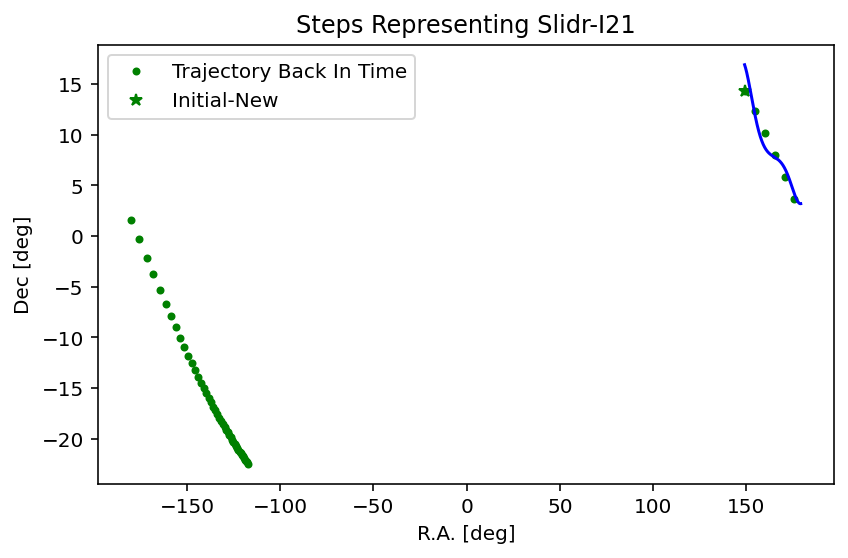

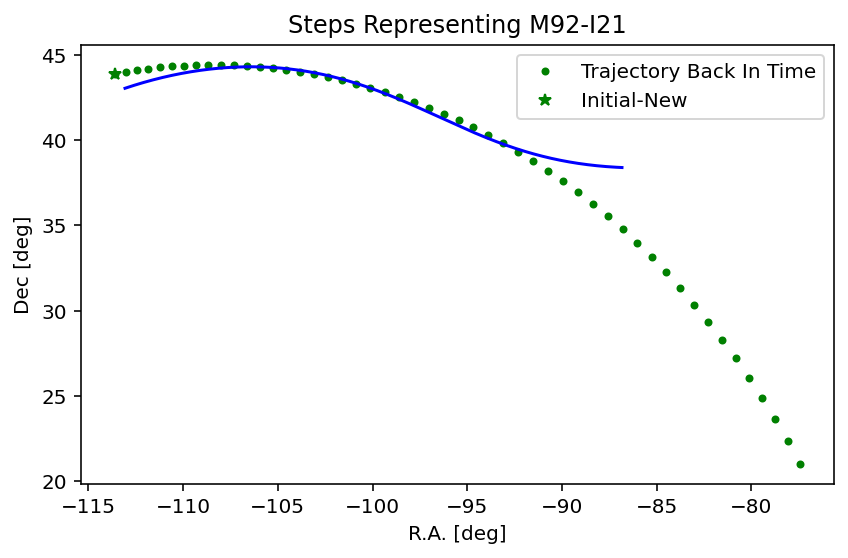

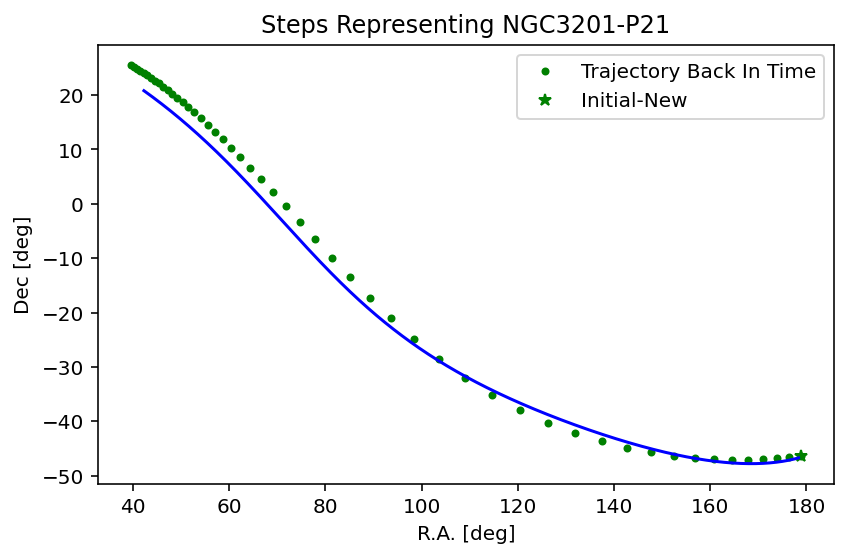

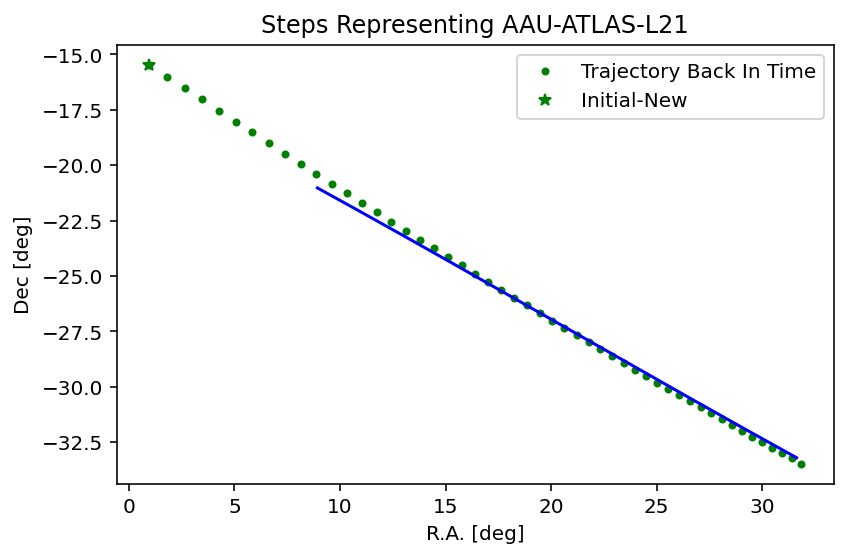

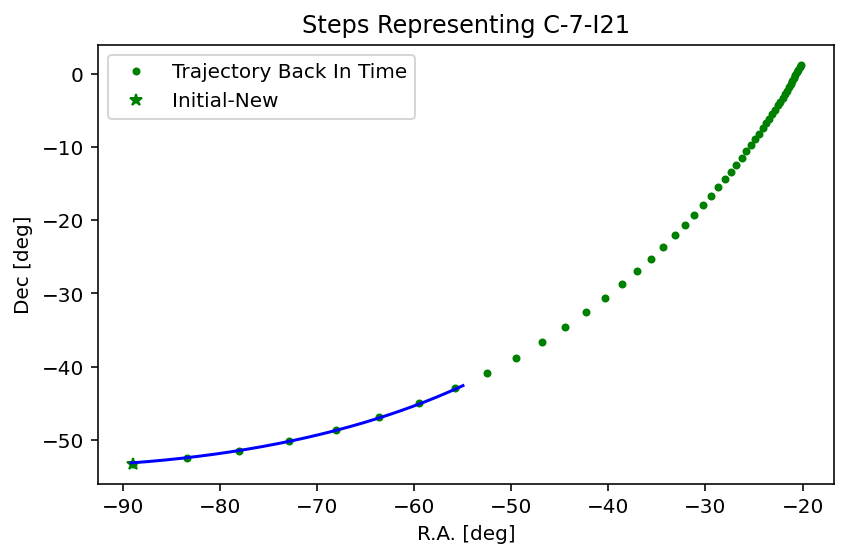

<Figure size 432x288 with 0 Axes>

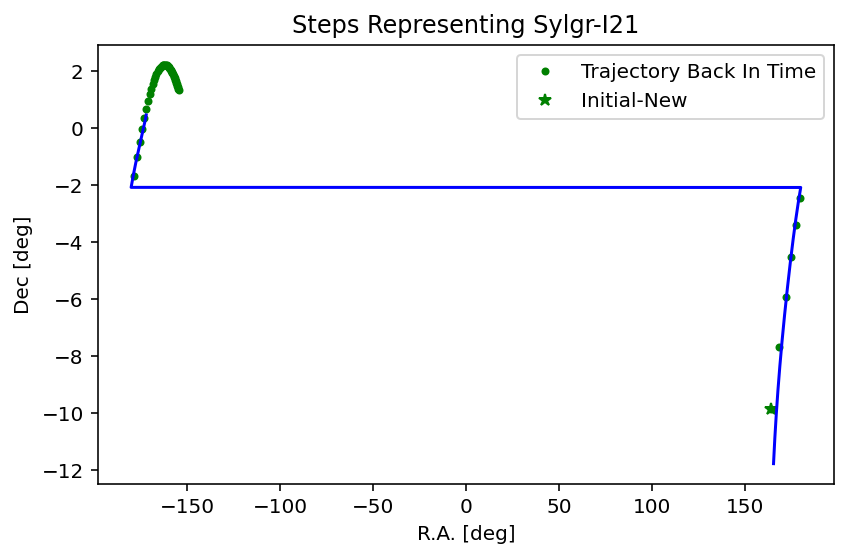

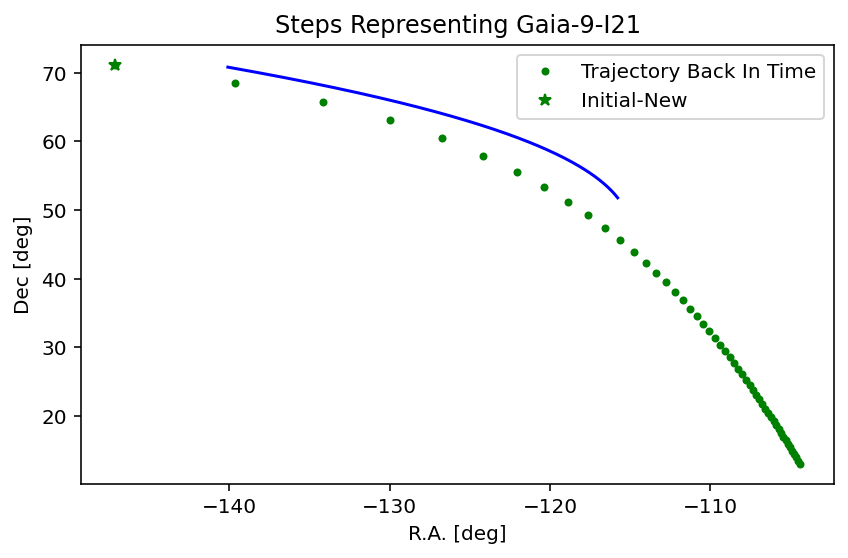

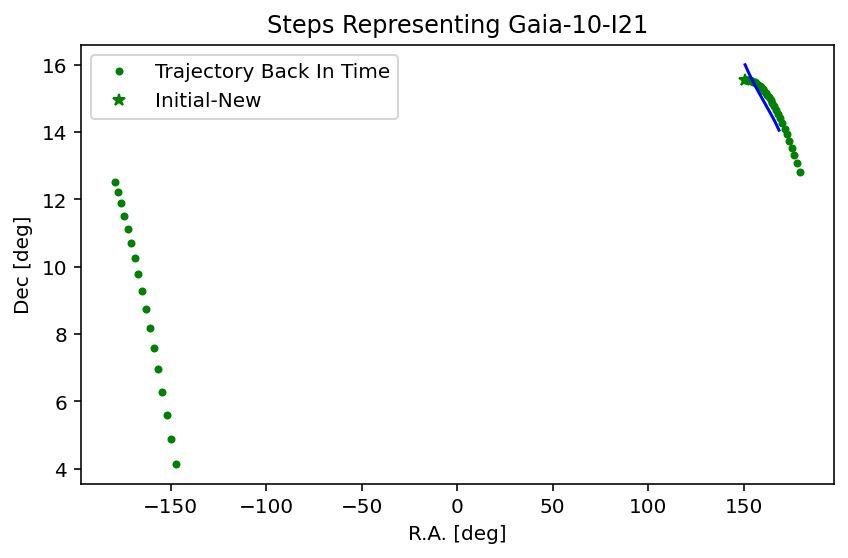

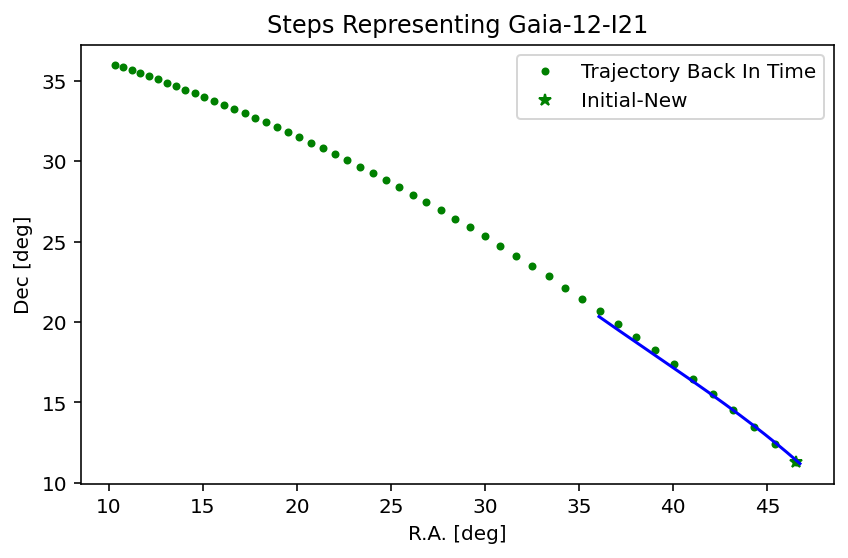

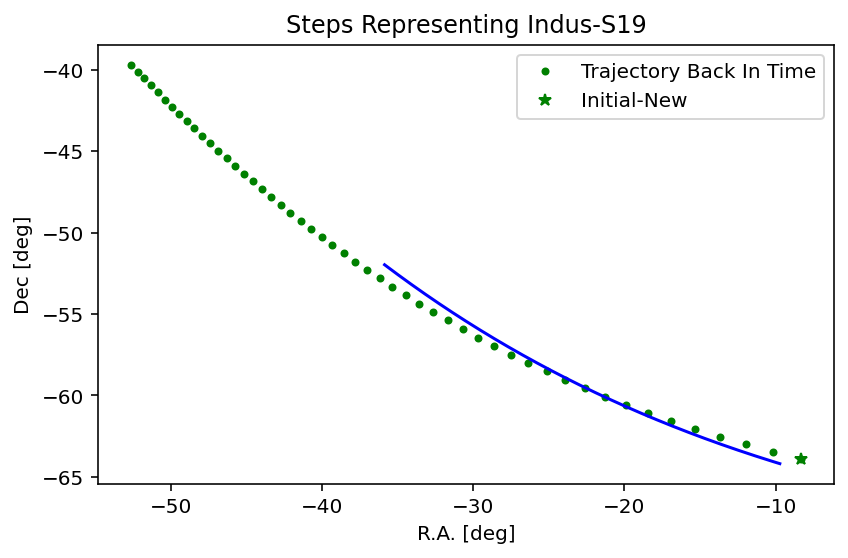

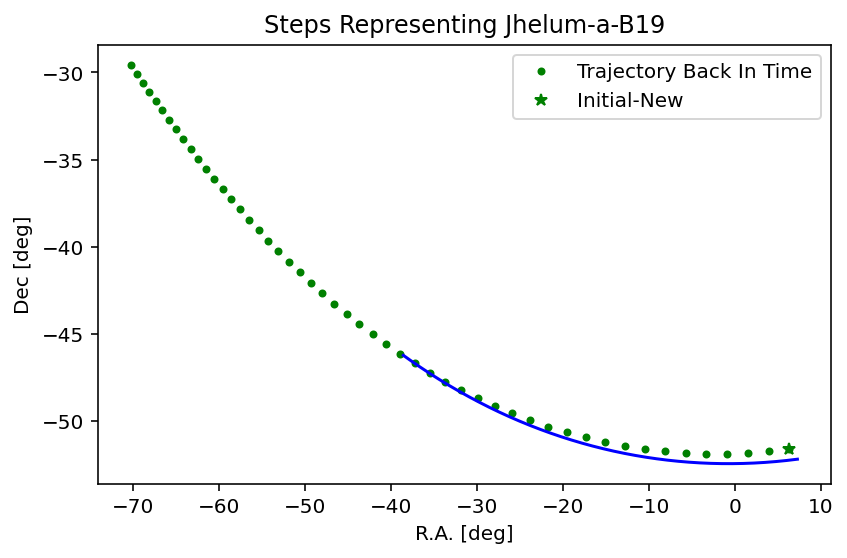

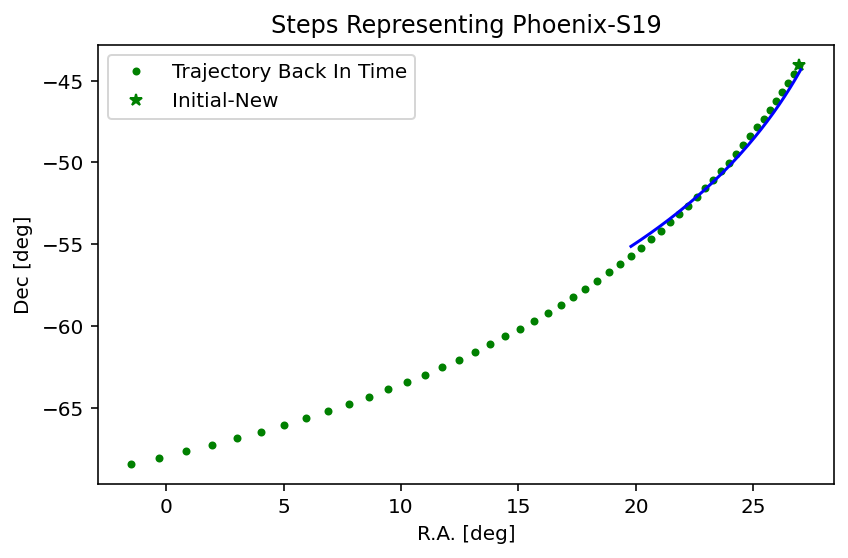

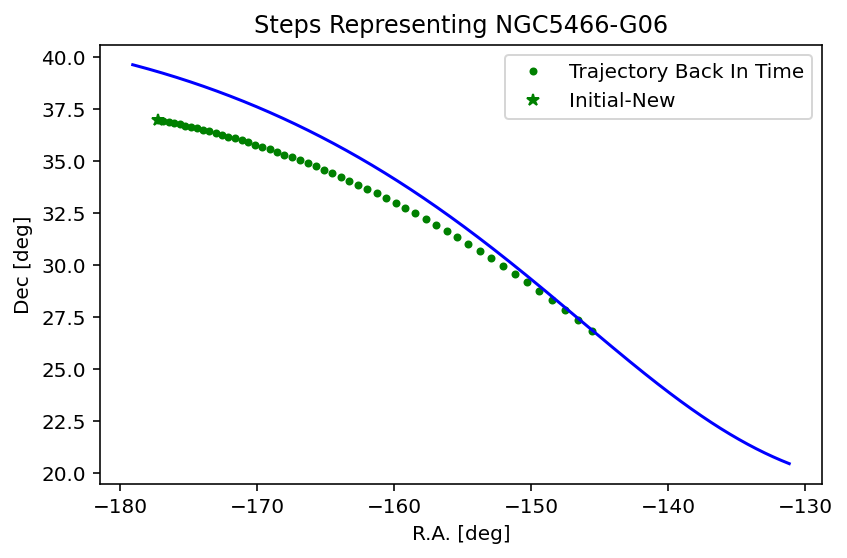

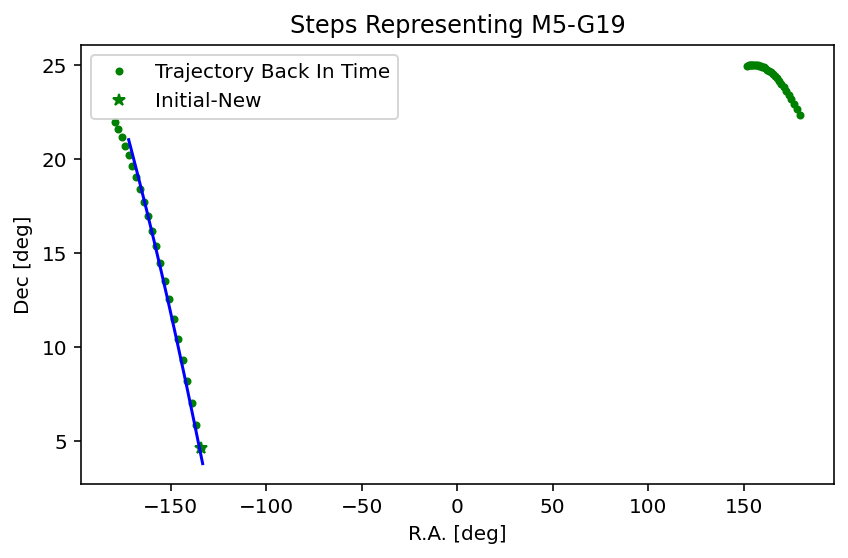

<Figure size 432x288 with 0 Axes>

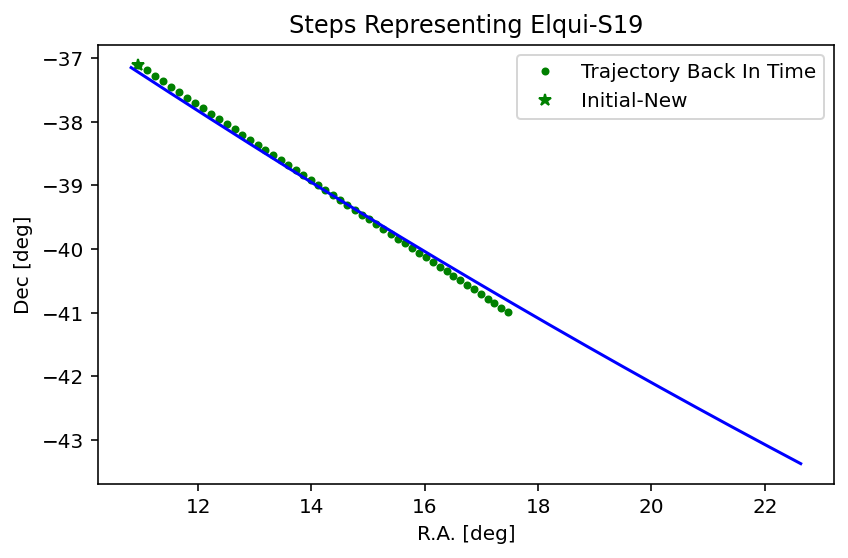

<Figure size 432x288 with 0 Axes>

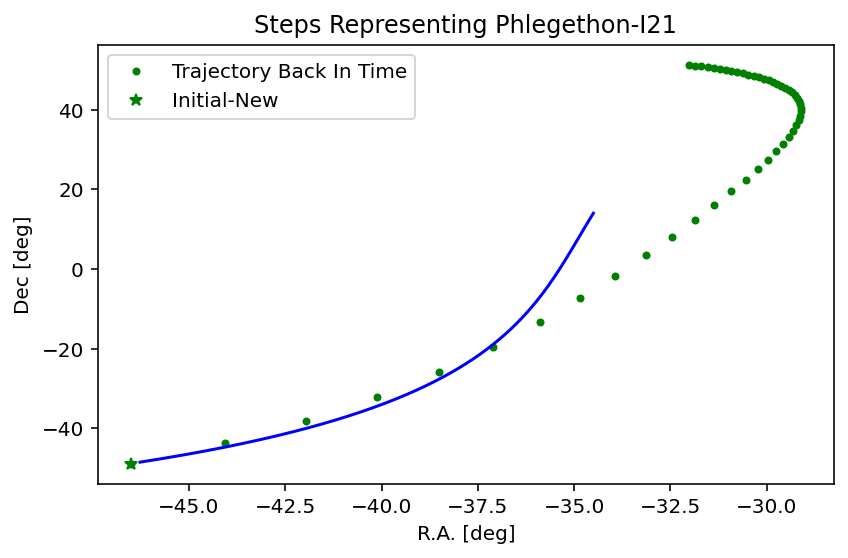

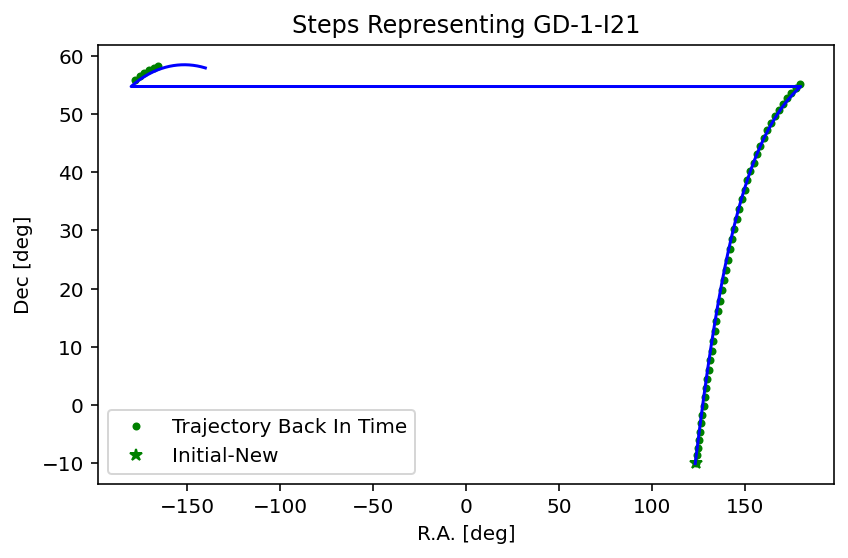

In [19]:
# define Galactocentric reference frame
coord.galactocentric_frame_defaults.set('v4.0')
gc_frame = coord.Galactocentric()
#define hamiltonian
ham = gp.Hamiltonian(gp.NFWPotential(m=MW_analog['mvir']/h*u.Msun, 
                                     r_s=(MW_analog['rs'])/h*u.kpc, units=galactic))

for i in range(len(names)):
    if list(names.values())[i] != 'None':
        c = coord.SkyCoord(ra=streams.iloc[i][1]*u.deg, dec=streams.iloc[i][2]*u.deg, distance=streams.iloc[i][3]*u.kpc, 
                           pm_ra_cosdec=streams.iloc[i][4]*u.mas/u.yr,pm_dec=streams.iloc[i][5]*u.mas/u.yr, 
                           radial_velocity=streams.iloc[i][6]*u.km/u.s, frame='icrs')
        w0 = gd.PhaseSpacePosition(c.transform_to(gc_frame).cartesian)

        name=list(names.values())[i] 
        
        plt.figure()
        dt = 1*u.Myr
        if type(list(Nstep_foward_dict.values())[i]) != str:
            Nstep_foward = list(Nstep_foward_dict.values())[i]
            orbit_foward = ham.integrate_orbit(w0, dt=dt, n_steps=Nstep_foward)
            orbit_foward_icrs = orbit_foward.to_coord_frame(coord.ICRS())

            #plt.savefig('Creating_Streams_Steps/New_Initial_Pos/'+name+'_New_Initial_Pos.png', transparent=False, dpi=200)
            w0_start = gd.PhaseSpacePosition(orbit_foward.pos[-1], orbit_foward.vel[-1])
            Nstep = 50 #this is a value to guess 
            orbit = ham.integrate_orbit(w0_start, dt=-dt, n_steps=Nstep)
            orbit_sky = orbit.to_coord_frame(coord.ICRS())

            plt.plot(orbit_sky.ra.wrap_at(180*u.deg), orbit_sky.dec, '.g', label='Trajectory Back In Time')
            plt.plot(orbit_sky.ra.wrap_at(180*u.deg)[0], orbit_sky.dec[0], '*g', label='Initial-New')
            plt.plot(mwsts[name].track.ra.wrap_at(180*u.deg), mwsts[name].track.dec, 'b-')
            plt.legend(loc='best')
            plt.title('Steps Representing '+name)
            plt.xlabel('R.A. [deg]')
            plt.ylabel('Dec [deg]')
            plt.tight_layout()

            

In [19]:
#Saving number of steps needed to represent the stream
Nstep_represent_dict = dict(Gjoll=36,Leiptr=29,
Hrid=12, Pal5=58, 
Gaia_1=7, Ylgr=27,
Fjorm=75, Kshir=14, 
Gunnthra=4, Slidr=5, 
M92=33, NGC_3201=43, 
Atlas=49, C_7=7, 
Palca='Unknown', Sylgr=10,
Gaia_9=9, Gaia_10=26, 
Gaia_12=10, Indus=23, 
Jhelum=21, Phoenix=22,
NGC5466=85, M5=17, 
C_20='None', C_19='Unknown',  
Elqui=85, AliqaUma='Unknown', 
Phlegethon=9, GD_1=58)

## Creating and Running Function for Dist, Time, Vel

In [32]:
# define Galactocentric reference frame
coord.galactocentric_frame_defaults.set('v4.0')
gc_frame = coord.Galactocentric()

#define hamiltonian
ham = gp.Hamiltonian(gp.NFWPotential(m=MW_analog['mvir']/h*u.Msun, 
                                     r_s=(MW_analog['rs'])/h*u.kpc, units=galactic))

def ClosestDist_new(streams):
    #Information for Stream 
    closest_dist1 = pd.DataFrame()
    for i in range(len(names)): #len(names)
        if ((list(names.values())[i] != 'None') & (list(Nstep_foward_dict.values())[i] != 'None') 
                                                  & (list(Nstep_foward_dict.values())[i] !='Unknown')):
            c = coord.SkyCoord(ra=streams.iloc[i][1]*u.deg, dec=streams.iloc[i][2]*u.deg, distance=streams.iloc[i][3]*u.kpc, 
                               pm_ra_cosdec=streams.iloc[i][4]*u.mas/u.yr,pm_dec=streams.iloc[i][5]*u.mas/u.yr, 
                               radial_velocity=streams.iloc[i][6]*u.km/u.s, frame='icrs')
            w0 = gd.PhaseSpacePosition(c.transform_to(gc_frame).cartesian)

            dt = 1*u.Myr
            Nstep_foward = list(Nstep_foward_dict.values())[i]
            orbit_foward = ham.integrate_orbit(w0, dt=dt, n_steps=Nstep_foward)
            orbit_foward_icrs = orbit_foward.to_coord_frame(coord.ICRS())

            #w0_start = gd.PhaseSpacePosition(orbit_foward.pos[-1], orbit_foward.vel[-1])
            w0_start = gd.PhaseSpacePosition(orbit_foward.pos, orbit_foward.vel)
            #instead of passing the orbit_foward.pos[-1], use orbit_foward.pos, same for orbit_foward.vel
            Nstep = list(Nstep_represent_dict.values())[i] 
            orbit = ham.integrate_orbit(w0_start, dt=-dt, n_steps=Nstep)
            orbit_sky = orbit.to_coord_frame(coord.ICRS())
            
            #Going back for 3 Gyrs (3000 steps of -1Myr)
            Nstep_long = 3000
            orbit_long = ham.integrate_orbit(w0_start, dt=-dt, n_steps=Nstep_long)

    
        
            data_new = {'Stream':[str(streams.iloc[i]['Stream'])]}
            data_temp = pd.DataFrame(data=data_new)
            
            for subh in range(len(trot['x'])): #subh stands for individual subhalo
                Npoint = np.shape(orbit_long.pos)[1]
                shape = np.shape(orbit_long.pos)
                #creating individual arrays to store information 
                distances_x = np.empty(shape)
                distances_y = np.empty(shape)
                distances_z = np.empty(shape)
                vel_x = np.empty(shape)
                vel_y = np.empty(shape)
                vel_z = np.empty(shape)
                
                
                for point in range(Npoint):
                    distances_x[:, point] = orbit_long.pos.x[:,point] - rot_orbits[subh,:,0]*u.kpc
                    distances_y[:, point] = orbit_long.pos.y[:,point] - rot_orbits[subh,:,1]*u.kpc
                    distances_z[:, point] = orbit_long.pos.z[:,point] - rot_orbits[subh,:,2]*u.kpc
                #for loop to subtract orbit_long.pos.x[i] - rot_orbits[subh,:,0]*u.kpc
                #then get the closest distance for every point in the stream and save the closest point
#                 dist_x = orbit_long.pos.x - rot_orbits[subh,:,0]*u.kpc 
#                 dist_y = orbit_long.pos.y - rot_orbits[subh,:,1]*u.kpc
#                 dist_z = orbit_long.pos.z - rot_orbits[subh,:,2]*u.kpc
                #dist_x, y, z, length of length of stream
                rel_dist = np.sqrt((distances_x**2)+(distances_y**2)+(distances_z**2)) 
                
                #trying out new code
                nrow = rel_dist.shape[0]
                ncol = rel_dist.shape[1]
                ind_min = np.argmin(rel_dist)
                ind_min_time = ind_min//ncol
                ind_min_dist = ind_min%ncol

                #For time
                time_occurance = -dt * ind_min_time
                #print(np.argmin(rel_dist), subh)
                #print(np.argmin(rel_dist, axis=0))

                #For velocity 
    #            ind_time = np.argmin(rel_dist)
                #will need the specific particle for which it came closest to 
                #then orbit_long.vel.d_x.to(u.km/u.s)[position] where position is the closest one 
    #                 vel_x = orbit_long.vel.d_x.to(u.km/u.s) - rot_orbits_vel[subh,:,0]*(u.km/u.s) 
    #                 vel_y = orbit_long.vel.d_y.to(u.km/u.s) - rot_orbits_vel[subh,:,1]*(u.km/u.s)
    #                 vel_z = orbit_long.vel.d_z.to(u.km/u.s) - rot_orbits_vel[subh,:,2]*(u.km/u.s)

    
                for point in range(len(orbit_long.pos)):
                    vel_x[point] = orbit_long.vel.d_x.to(u.km/u.s)[ind_min_time,ind_min_dist] - rot_orbits_vel[subh,:,0]*(u.km/u.s)
                    vel_y[point] = orbit_long.vel.d_y.to(u.km/u.s)[ind_min_time,ind_min_dist] - rot_orbits_vel[subh,:,1]*(u.km/u.s)
                    vel_z[point] = orbit_long.vel.d_z.to(u.km/u.s)[ind_min_time,ind_min_dist] - rot_orbits_vel[subh,:,2]*(u.km/u.s)
                rel_vel = np.sqrt((vel_x**2) + (vel_y**2) + (vel_z**2))

                data_temp['Subhalo_'+ str(subh)+ ' Distance (kpc)'] = [closest_dist2.value]
                data_temp['Subhalo_'+ str(subh)+ ' Time (Myr)'] = [time_occurance.value]
                data_temp['Subhalo_'+ str(subh)+ ' Relative Velocity (km/s)'] = [rel_vel[ind_time].value]

            closest_dist1 = closest_dist1.append(data_temp, ignore_index=True)
    return closest_dist1




In [33]:
pb_test = ClosestDist_new(streams)

ValueError: could not broadcast input array from shape (3001,) into shape (21,)

In [27]:
i=1
c = coord.SkyCoord(ra=streams.iloc[i][1]*u.deg, dec=streams.iloc[i][2]*u.deg, distance=streams.iloc[i][3]*u.kpc, 
                               pm_ra_cosdec=streams.iloc[i][4]*u.mas/u.yr,pm_dec=streams.iloc[i][5]*u.mas/u.yr, 
                               radial_velocity=streams.iloc[i][6]*u.km/u.s, frame='icrs')
w0 = gd.PhaseSpacePosition(c.transform_to(gc_frame).cartesian)

dt = 1*u.Myr
Nstep_foward = list(Nstep_foward_dict.values())[i]
orbit_foward = ham.integrate_orbit(w0, dt=dt, n_steps=Nstep_foward)
orbit_foward_icrs = orbit_foward.to_coord_frame(coord.ICRS())

#w0_start = gd.PhaseSpacePosition(orbit_foward.pos[-1], orbit_foward.vel[-1])
w0_start = gd.PhaseSpacePosition(orbit_foward.pos, orbit_foward.vel)
#instead of passing the orbit_foward.pos[-1], use orbit_foward.pos, same for orbit_foward.vel
Nstep = list(Nstep_represent_dict.values())[i] 
orbit = ham.integrate_orbit(w0_start, dt=-dt, n_steps=Nstep)
orbit_sky = orbit.to_coord_frame(coord.ICRS())

#Going back for 3 Gyrs (3000 steps of -1Myr)
Nstep_long = 3000
orbit_long = ham.integrate_orbit(w0_start, dt=-dt, n_steps=Nstep_long)
orbit_long.vel.shape
#time step , dist

(3001, 11)

In [28]:
for subh in range(len(trot['x'])): #subh stands for individual subhalo
                Npoint = np.shape(orbit_long.pos)[1]
                shape = np.shape(orbit_long.pos)
                #creating individual arrays to store information 
                distances_x = np.empty(shape)
                distances_y = np.empty(shape)
                distances_z = np.empty(shape)
                vel_x = np.empty(shape)
                vel_y = np.empty(shape)
                vel_z = np.empty(shape)
                
                
                for point in range(Npoint):
                    distances_x[:, point] = orbit_long.pos.x[:,point] - rot_orbits[subh,:,0]*u.kpc
                    distances_y[:, point] = orbit_long.pos.y[:,point] - rot_orbits[subh,:,1]*u.kpc
                    distances_z[:, point] = orbit_long.pos.z[:,point] - rot_orbits[subh,:,2]*u.kpc
                #for loop to subtract orbit_long.pos.x[i] - rot_orbits[subh,:,0]*u.kpc
                #then get the closest distance for every point in the stream and save the closest point
#                 dist_x = orbit_long.pos.x - rot_orbits[subh,:,0]*u.kpc 
#                 dist_y = orbit_long.pos.y - rot_orbits[subh,:,1]*u.kpc
#                 dist_z = orbit_long.pos.z - rot_orbits[subh,:,2]*u.kpc
                #dist_x, y, z, length of length of stream
                rel_dist = np.sqrt((distances_x**2)+(distances_y**2)+(distances_z**2)) 
                
                #trying out new code
                nrow = rel_dist.shape[0]
                ncol = rel_dist.shape[1]
                ind_min = np.argmin(rel_dist)
                ind_min_time = ind_min//ncol
                ind_min_dist = ind_min%ncol

In [29]:

orbit_long.vel.d_x.to(u.km/u.s)[ind_min_time,ind_min_dist]

<Quantity 103.59945374 km / s>

In [31]:
nrow = rel_dist.shape[0]
ncol = rel_dist.shape[1]

In [27]:
def min_2d():
    """Find the indices of the minimum value in a 2D array"""
   
    # fix the random number generator
    np.random.seed(193)
   
    # generate the 2D array (3x4)
    nrow = 3
    ncol = 4
    M = np.random.random((nrow,ncol))
   
    # check the array
    print(M)
   
    ind_min = np.argmin(M)
    ind_min_row = ind_min//ncol
    ind_min_col = ind_min%ncol
   
    # test -- these should all return the same number
    print(np.min(M)) # get the minimum value directly
    print(M.ravel()[ind_min]) # get the minimum value by indexing a flattened array (ravel flattens the array)
    print(M[ind_min_row, ind_min_col]) # get the minimum value by indexing into a 2D array

In [33]:
np.shape(orbit_long.pos) #time seq, diff points 

(3001, 36)

In [28]:
rot_orbits[0,:,0]*u.kpc

<Quantity [-1.95993464, -2.00267377, -2.04540161, ..., 40.56488813,
           40.55042372, 40.53591353] kpc>

In [29]:
len(rot_orbits[0,:,0])

3001

In [26]:
# pb= ClosestDist_new(streams)
# pb

,Stream,Subhalo_0 Distance (kpc),Subhalo_0 Time (Myr),Subhalo_0 Relative Velocity (km/s),Subhalo_1 Distance (kpc),Subhalo_1 Time (Myr),Subhalo_1 Relative Velocity (km/s),Subhalo_2 Distance (kpc),Subhalo_2 Time (Myr),Subhalo_2 Relative Velocity (km/s),...,Subhalo_1068 Relative Velocity (km/s),Subhalo_1069 Distance (kpc),Subhalo_1069 Time (Myr),Subhalo_1069 Relative Velocity (km/s),Subhalo_1070 Distance (kpc),Subhalo_1070 Time (Myr),Subhalo_1070 Relative Velocity (km/s),Subhalo_1071 Distance (kpc),Subhalo_1071 Time (Myr),Subhalo_1071 Relative Velocity (km/s)
0,Gjoll,20.844819,-292.0,513.625381,87.639965,-2623.0,295.161964,285.447854,-0.0,347.652723,...,443.848340,42.869491,-1394.0,619.773032,57.684543,-633.0,384.010188,35.003404,-867.0,404.432585
1,Leiptr,7.464532,-330.0,436.723017,97.933196,-1234.0,311.202620,289.117595,-0.0,354.074380,...,720.141464,32.601127,-1420.0,436.428933,67.941711,-634.0,631.187426,50.317797,-2420.0,444.074607
2,Hrid,55.704337,-300.0,415.709288,97.233570,-222.0,262.543720,278.609344,-0.0,468.771412,...,541.300024,9.737199,-1418.0,427.641734,46.155459,-653.0,467.275063,32.011735,-792.0,369.179585
3,Pal5,33.089881,-230.0,581.213187,107.370952,-2697.0,312.818478,273.307496,-0.0,129.455421,...,624.598637,14.571639,-1389.0,450.388679,53.199846,-656.0,664.836331,39.760653,-2326.0,490.197771
4,Gaia_1,30.582918,-405.0,440.698356,81.634673,-2329.0,378.922074,272.914886,-100.0,144.060153,...,479.138155,21.851384,-1420.0,899.893636,58.353915,-713.0,869.674637,35.773766,-710.0,722.152783
5,Ylgr,30.756110,-285.0,624.991270,102.440056,-2276.0,350.570348,285.921091,-0.0,230.066140,...,638.475559,2.717715,-1397.0,431.370691,53.126955,-746.0,286.184292,26.183638,-808.0,467.950142
6,Fjorm,58.691746,-189.0,464.264799,94.768240,-289.0,208.196861,274.971429,-0.0,518.530834,...,415.984096,8.223526,-1478.0,503.665195,58.697893,-659.0,515.950945,40.190877,-2438.0,628.892809
7,Kshir,41.454503,-244.0,632.958246,102.760077,-2788.0,438.502541,274.090370,-0.0,131.091571,...,602.118112,26.704248,-1420.0,685.589891,63.145164,-712.0,600.017982,27.499217,-724.0,504.070417
8,Gunnthra,38.641255,-292.0,408.680141,110.529996,-2848.0,299.439980,283.521771,-0.0,233.426221,...,584.795559,16.570570,-1410.0,725.325367,59.136175,-667.0,489.305804,41.537009,-726.0,451.121455
9,Slidr,41.036184,-301.0,511.147252,103.437170,-248.0,348.393516,281.807700,-0.0,368.855681,...,553.687188,22.117424,-1367.0,606.723956,49.904962,-784.0,411.331282,25.106130,-752.0,476.455107


In [ ]:
plt.plot(rel_dist)

In [ ]:
plt.plot(pb.iloc[4][1::3], pb.iloc[4][2::3], '.')
plt.xlabel('Relative Distance')
plt.ylabel('Time of Encounter')

In [ ]:
 pb.iloc[4]

In [ ]:
#Saving pb
pb.to_csv('Closest_Distance_Subhalo_to_All_Streams.csv', index='False')

In [ ]:
pb = pd.read_csv('Closest_Distance_Subhalo_to_All_Streams.csv')
pb = pb.drop("Unnamed: 0",axis=1)

In [ ]:
pb

## Velocity vs Distance Graph

In [ ]:
#Creating Visualization of Subhalo impact on streams (distance vs velocity kick)
for i in range(len(pb)):
    plt.figure()
    for subh in range(len(trot)):
        plt.scatter(pb['Subhalo_'+str(subh)+' Distance (kpc)'][i],pb['Subhalo_'+str(subh)+' Relative Velocity (km/s)'][i], color='blue') 
    plt.xlabel('Distance [kpc]')
    plt.ylabel('Velocity [km/s]')
    plt.title('Distance vs Velocity: '+str(pb.iloc[i][0]))
    plt.savefig('Distance_vs_Velocity/'+str(pb.iloc[i][0])+'.png', transparent=False, dpi=200)
    

## Calculation for Vel Kick

In [ ]:
#Calculation of Velocity Kick WITH LMC
vel_kick = (np.empty(len(pb)))*(u.m**3*u.M_sun/(u.kg*u.km*u.kpc*u.s))
#delta_v_individual_info = np.zeros(len(ts[ind_massive]['mvir'])) #creating an empty array to store ind delta v 
#there are 1072 contributions to velocity changes per stream
data_all = pd.DataFrame()
for i in range(len(pb)):
    
    #Calculating Velocity Kick 
    G = (6.6743*10**(-11))*(u.m**3/(u.kg*u.s**2)) #gravitational constant
    r_min = np.array(pb.iloc[i][1::3])*u.kpc  #smallest distance between subhalos and stream 
    v_rel = np.array(pb.iloc[i][3::3])*(u.km/u.s) #relative vel btwn stream and subhalos 
    mass_subh = (np.array(ts[ind_massive]['mvir']))*u.M_sun #mass of subhalos
    delta_v = 2*G*mass_subh/(r_min*v_rel) 
    
    #print(str(pb.iloc[i][0]), str(delta_v.to(u.km/u.s)[0]))

    plt.figure()
    delta_v_km_new = delta_v.to(u.km/u.s)
    plt.hist(delta_v_km_new.value, bins=np.logspace(-4,2,30) , color='blue', alpha=0.7)
    plt.gca().set_xscale('log') 
    plt.xlabel('Velocity Kick')
    plt.ylabel('Total Number of Subhalos')
    plt.title(str(pb.iloc[i][0])+' with LMC')
    plt.savefig('Vel_Kick_Histogram_with_LMC/'+str(pb.iloc[i][0])+'.png', transparent=False, dpi=200)
    
    
    vel_kick_temp = np.sqrt(np.sum(delta_v**2))
    vel_kick[i] = vel_kick_temp
vel_kick


    


In [ ]:
#Calculation of Velocity Kick Without LMC
# Add units 
vel_kick_no_LMC = (np.empty(len(pb)))*(u.m**3*u.M_sun/(u.kg*u.km*u.kpc*u.s))
#max_vel_kick_no_LMC = vel_kick_new
for i in range(len(pb)):
    G = (6.6743*10**(-11))*(u.m**3/(u.kg*u.s**2)) #gravitational constant
    r_min = np.array(pb.iloc[i][1::3])*u.kpc  #smallest distance between subhalos and stream 
    v_rel = np.array(pb.iloc[i][3::3])*(u.km/u.s) #relative vel btwn stream and subhalos 
    mass_subh = (np.array(ts[ind_massive]['mvir']))*u.M_sun #mass of subhalos
    delta_v = 2*G*mass_subh/(r_min*v_rel) 
    
    delta_v = delta_v[1:] #simply removing the change in velocity due to first index (LMC)
    
    plt.figure()
    delta_v_km_new = delta_v.to(u.km/u.s)
    plt.hist(delta_v_km_new.value, bins=np.logspace(-4,2,30) , color='blue', alpha=0.7)
    plt.gca().set_xscale('log') 
    plt.xlabel('Velocity Kick without LMC')
    plt.ylabel('Total Number of Subhalos')
    plt.title(str(pb.iloc[i][0])+' without LMC')
    plt.savefig('Vel_Kick_Histogram_without_LMC/'+str(pb.iloc[i][0])+'.png', transparent=False, dpi=200) 
    
    vel_kick_temp = np.sqrt(np.sum(delta_v[1:]**2))
    vel_kick_no_LMC[i] = vel_kick_temp
vel_kick_no_LMC 



#use .decompe for SI units

In [ ]:
#Calculation of Velocity Kick Without LMC
# With the addition of the Plot 
colors = ['black', 'silver', 'rosybrown', 'red', 'sienna',
         'tan', 'moccasin', 'gold', 'darkkhaki', 'olivedrab', 
         'chartreuse', 'darkgreen', 'lightseagreen', 'paleturquoise',
         'deepskyblue', 'slategray', 'royalblue', 'darkorange', 'darkgoldenrod',
         'lawngreen', 'mediumseagreen', 'mediumpurple', 'darkorchid', 'plum', 
         'm', 'palevioletred', 'violet', 'c', 'olive', 'lemonchiffon', 'skyblue',
         'indigo']

vel_kick_no_LMC = (np.empty(len(pb)))*(u.m**3*u.M_sun/(u.kg*u.km*u.kpc*u.s))
for i in range(len(pb)):   
    #Calculating Velocity Kick 
    G = (6.6743*10**(-11))*(u.m**3/(u.kg*u.s**2)) #gravitational constant
    r_min = np.array(pb.iloc[i][1::3])*u.kpc  #smallest distance between subhalos and stream 
    v_rel = np.array(pb.iloc[i][3::3])*(u.km/u.s) #relative vel btwn stream and subhalos 
    mass_subh = (np.array(ts[ind_massive]['mvir']))*u.M_sun #mass of subhalos
    delta_v = 2*G*mass_subh/(r_min*v_rel) 
    
    #plt.figure()
    delta_v_km_new = delta_v.to(u.km/u.s)
    
    plt.hist(delta_v_km_new.value,bins=np.logspace(-4,2,30), color=colors[i], alpha=0.9,
         histtype='step', linewidth=2)
    plt.axvline(delta_v_km_new[0].value, color=colors[i], linewidth=2)
    
    plt.gca().set_xscale('log') 

    
    vel_kick_temp = np.sqrt(np.sum(delta_v[1:]**2))
    vel_kick_no_LMC[i] = vel_kick_temp
vel_kick_no_LMC 

plt.xlabel('Velocity Kick with LMC')
plt.ylabel('Total Number of Subhalos')
plt.title('Velocity Kick with LMC for All Streams')
plt.savefig('Vel_Kick_Histogram_with_LMC/All_Stream_Vel_Kick_With_LMC.png', transparent=False, dpi=200) 



## Additing Info to Streams

In [ ]:
r_peri = dict(LMS_1=10.8, Gjoll=8.5, Leiptr=12.3, Hrid=1.1, Pal5=6.9, Orphan=15.6, 
             Gaia_1=8.2, Fimbulthul=2.4, Ylgr=11.5, Fjorm=9.1, Kshir=13.4, Cetus=14.7,
             Svol=5.9, Gunnthra=4.2, Slidr=8.7, M92=3.0, NGC_6397=3.4, NGC_3201=8.5,
             Ophiuchus=3.9, Atlas=11.7, C_7=3.5, C_3=5.7, Palca=10.8, Sylgr=8.7,
             Gaia_6=6.0, Gaia_9=8.7, Gaia_10=4.3, Gaia_12=18.5, Indus=12.6, Jhelum=8.7,
             Phoenix=11.7, NGC5466=4.8, M5=3.4, C_20=20.8, NGC7089=2.9, C_19=9.3,
             Elqui=12.1, Chenab=22.0, AliqaUma=11.6, Phlegethon=5.5, GD_1=14.1)


r_apo = dict(LMS_1=20.6, Gjoll=27.4, Leiptr=45.1, Hrid=22.0, Pal5=15.8, Orphan=41.2, 
             Gaia_1=67.6, Fimbulthul=7.2, Ylgr=20.7, Fjorm=29.1, Kshir=16.0, Cetus=35.9,
             Svol=10.0, Gunnthra=7.2, Slidr=32.3, M92=10.7, NGC_6397=6.4, NGC_3201=30.5,
             Ophiuchus=14.2, Atlas=32.4, C_7=21.0, C_3=10.0, Palca=16.5, Sylgr=24.6,
             Gaia_6=9.5, Gaia_9=20.8, Gaia_10=37.7, Gaia_12=194.3, Indus=18.9, Jhelum=24.5,
             Phoenix=18.1, NGC5466=33.7, M5=24.8, C_20=58.5, NGC7089=14.7, C_19=21.6,
             Elqui=54.0, Chenab=81.0, AliqaUma=31.9, Phlegethon=22.1, GD_1=23.0)


In [ ]:
streams['r_apo'] = np.nan
streams['r_peri'] = np.nan

streams_copy = streams.copy()

for i in range(len(streams['Stream'][:])):
    if streams['Stream'][i] in list(r_apo.keys()):
        streams_copy['r_apo'][i] = r_apo[streams['Stream'][i]]
        streams_copy['r_peri'][i] = r_peri[streams['Stream'][i]]
        

In [ ]:
streams_copy

In [ ]:
streams_copy.to_csv('Streams_data.csv', index='False')


In [ ]:
streams = pd.read_csv('Streams_data.csv')
streams = streams.drop("Unnamed: 0",axis=1)

In [ ]:
streams

In [ ]:
streams_copy = streams.copy()
streams_copy['vel_kick'] = np.nan
vel_kick_km_s = vel_kick.to(u.km/u.s)
j=0
for i in range(len(list(Nstep_represent_dict.values()))):
    if ((list(Nstep_foward_dict.values())[i] != 'None') & (list(Nstep_foward_dict.values())[i] !='Unknown')):
        streams_copy['vel_kick'][i] = vel_kick_km_s[j]
        j+=1

In [ ]:
streams_copy

In [ ]:
streams_copy.to_csv('Streams_data_with_velkick.csv', index='False')

In [ ]:
streams_copy['vel_kick_no_LMC'] = np.nan

In [ ]:
streams_copy_new = streams_copy.copy()
vel_kick_no_LMC_km_s = vel_kick_no_LMC.to(u.km/u.s)
j=0
for i in range(len(list(Nstep_represent_dict.values()))):
    if ((list(Nstep_foward_dict.values())[i] != 'None') & (list(Nstep_foward_dict.values())[i] !='Unknown')):
        streams_copy_new['vel_kick_no_LMC'][i] = vel_kick_no_LMC_km_s[j]
        j+=1

In [ ]:
streams_copy_new

In [ ]:
streams_copy_new.to_csv('Streams_data_with_velkick_NO_LMC.csv', index='False')

In [ ]:
streams_copy_new = pd.read_csv('Streams_data_with_velkick_NO_LMC.csv')
streams_copy_new = streams_copy_new.drop("Unnamed: 0",axis=1)

In [ ]:
streams_copy_new

In [ ]:
#Adding length to streams 
length = dict(Gjoll=mwsts['NGC3201-P21'].length.deg, Leiptr=mwsts['Leiptr-I21'].length.deg, 
              Hrid=mwsts['Hrid-I21'].length.deg, Pal5=mwsts['Pal15-M17'].length.deg, #Pal5 has 2
              Gaia_1=mwsts['Gaia-1-I21'].length.deg, Ylgr=mwsts['Ylgr-I21'].length.deg, 
              Fjorm=mwsts['M68-P19'].length.deg, Kshir=mwsts['Kshir-I21'].length.deg, 
              Gunnthra=mwsts['Gunnthra-I21'].length.deg, Slidr=mwsts['Slidr-I21'].length.deg, 
              M92=mwsts['M92-I21'].length.deg, NGC_3201=mwsts['NGC3201-P21'].length.deg,
              Atlas=mwsts['AAU-ATLAS-L21'].length.deg, C_7=mwsts['C-7-I21'].length.deg, 
              Palca=mwsts['Palca-S18'].length.deg, Sylgr=mwsts['Sylgr-I21'].length.deg,
              Gaia_9=mwsts['Gaia-9-I21'].length.deg, Gaia_10=mwsts['Gaia-10-I21'].length.deg, 
              Gaia_12=mwsts['Gaia-12-I21'].length.deg, Indus=mwsts['Indus-S19'].length.deg, 
              Jhelum=mwsts['Jhelum-a-B19'].length.deg, Phoenix=mwsts['Phoenix-S19'].length.deg, #Jhelum has 2
              NGC5466=mwsts['NGC5466-G06'].length.deg, M5=mwsts['M5-G19'].length.deg, 
              C_20='0', C_19=mwsts['C-9-I21'].length.deg,
              Elqui=mwsts['Elqui-S19'].length.deg, AliqaUma=mwsts['AAU-AliqaUma-L21'].length.deg, 
              Phlegethon=mwsts['Phlegethon-I21'].length.deg, GD_1=mwsts['GD-1-I21'].length.deg)

In [ ]:
streams_copy_new['length [deg]'] = np.nan

streams_copy_new_updated = streams_copy_new.copy()

for i in range(len(streams_copy_new['Stream'][:])):
    streams_copy_new_updated['length [deg]'][i] = list(length.values())[i]

In [ ]:
streams_copy_new_updated.to_csv('Streams_data_with_velkicks_and_len.csv', index='False')
streams_copy_new_updated = pd.read_csv('Streams_data_with_velkicks_and_len.csv')
streams_copy_new_updated = streams_copy_new_updated.drop("Unnamed: 0",axis=1)

## Plots with Covariance

In [ ]:
plt.figure()
plt.plot(streams_copy_new['r_apo'], streams_copy_new['r_peri'], '.', ms=15)
plt.xlabel('Streams Apocenter')
plt.ylabel('Streams Pericenter')
plt.title('Streams Apocenter vs Pericenter')

In [ ]:
corr_apo_peri = np.corrcoef(streams_copy_new['r_apo'], streams_copy_new['r_peri'])
corr_apo_peri

In [ ]:
plt.figure()
plt.plot(streams_copy_new['r_peri'], streams_copy_new['vel_kick'], '.', ms=15)
plt.xlabel('Streams Pericenter')
plt.ylabel('Streams Velocity Kick')
plt.title('Streams Pericenter vs Velocity Kick')

In [ ]:
corr_peri_velkick = np.corrcoef(streams_copy_new['r_peri'], streams_copy_new['vel_kick'])
corr_peri_velkick

In [ ]:
plt.figure()
plt.plot(streams_copy_new['r_apo'], streams_copy_new['vel_kick'], '.', ms=15)
plt.xlabel('Streams Apo')
plt.ylabel('Streams Velocity Kick')
plt.title('Streams Apo vs Velocity Kick')

In [ ]:
corr_apo_velkick = np.corrcoef(streams_copy_new['r_apo'], streams_copy_new['vel_kick'])
corr_apo_velkick

In [ ]:
plt.figure()
plt.plot(streams_copy_new['r_peri'], streams_copy_new['vel_kick_no_LMC'], '.', ms=15)
plt.xlabel('Streams Pericenter')
plt.ylabel('Streams Velocity Kick No LMC')
plt.title('Streams Pericenter vs Velocity Kick No LMC')

In [ ]:
corr_peri_velkicknoLMC = np.corrcoef(streams_copy_new['r_peri'], streams_copy_new['vel_kick_no_LMC'])
corr_peri_velkicknoLMC

In [ ]:
plt.figure()
plt.plot(streams_copy_new['r_apo'], streams_copy_new['vel_kick_no_LMC'], '.', ms=15)
plt.xlabel('Streams Apo')
plt.ylabel('Streams Velocity Kick No LMC')
plt.title('Streams Apo vs Velocity Kick No LMC')

In [ ]:
corr_apo_velkicknoLMC = np.corrcoef(streams_copy_new['r_apo'], streams_copy_new['vel_kick_no_LMC'])
corr_apo_velkicknoLMC

### Emphasizing Streams with Largest Vel Kicks

In [ ]:
diff_velkicks = np.abs(streams_copy_new['vel_kick_no_LMC'] - streams_copy_new['vel_kick'])

x = np.linspace(1,30,30)
plt.figure()
plt.plot(x, diff_velkicks, '.', ms=15)
plt.plot(x[diff_velkicks>100], diff_velkicks[diff_velkicks>100], '.', 
         color= 'pink', ms=15, label='Vel Kick > 100 km/s')

# feed back from lmc generically heats up the streams 
#str(mwsts[str(streams_copy_new['Stream'][diff_velkicks>100])].length.deg))
#Need Help Adding Names 

plt.xlabel('Streams')
plt.ylabel('Difference in Velocity Kicks')
plt.legend(loc='best')
plt.title('Absolute Difference in Velocity Kicks Per Stream')

In [ ]:
streams_copy_new['Stream'][diff_velkicks>100]

In [ ]:
#Smallest Distance on y axis and apocenter on x axis for all streams

In [ ]:
#Creates Histograms for All Streams 
#Include both Apocenter and Pericenter
for i in range(len(pb)):
    plt.figure()
    plt.hist(pb.iloc[i][1::3], bins=np.linspace(-1,200,50), color='blue', alpha=0.7, label='Subhalos');  
    plt.axvline(min(pb.iloc[i][1::3]), color='black', label = 'Smallest Distance: {:.3f} kpc'.format(min(pb.iloc[i][1::3])))
    for key in range(len(r_apo.keys())):
        if pb.iloc[i][0] == list(r_apo.keys())[key]:
            plt.axvline(r_apo[pb.iloc[i][0]], color='red', label = 'Apocenter: {:.3f} kpc'.format(r_apo[pb.iloc[i][0]]))
    plt.title('Closest Distance Between {:s} to Subhalos'.format(pb.iloc[i][0]))
    plt.xlabel('Distance to Subhalo (kpc)')
    plt.ylabel('Total Number of Subhalos')
    plt.legend(loc='best')
    plt.savefig('Stream_to_Subhalo_Histograms/'+str(pb.iloc[i][0])+'.png', transparent=False, dpi=200)
    
    

## Paper Plots

### Streams Distance to Galactic Center

In [ ]:
#%matplotlib notebook
fig = plt.figure(1,figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
for st in mwsts.keys():
    ax.scatter3D(mwsts[st].track.transform_to(gsr).x,mwsts[st].track.transform_to(gsr).y,
                 mwsts[st].track.transform_to(gsr).z,
                 marker='.', color='red', s=1, c=None, alpha=1)
ax.scatter3D(trot['x'][1:], trot['y'][1:], trot['z'][1:], color='blue', label='Subhalos', s=10*(trot['rs'][1:]), alpha=1)    
ax.scatter3D(trot['x'][0], trot['y'][0], trot['z'][0], marker='*', color='orange', s=50*trot['rs'][0], 
             label='LMC Analog', alpha=1)
ax.set_xlim3d(-200, 200)
ax.set_ylim3d(-200, 200)
ax.set_zlim3d(-200, 200)
ax.set_xlabel('X [kpc]')
ax.set_ylabel('Y [kpc]')
ax.set_zlabel('Z [kpc]')
plt.legend(loc='best', markerscale=0.6)
plt.title('Stellar Streams and Subhalo Distance to Galactic Center')
plt.savefig('Stellar_Streams_and_Subhalo_Distance_to_Galactic_Center.png', transparent=False, dpi=200)
                 

### Orbit of Gaia-1 in Past 3Gyrs

In [ ]:
#Orbit time step for Gaia-1

# define Galactocentric reference frame
coord.galactocentric_frame_defaults.set('v4.0')
gc_frame = coord.Galactocentric()

ham = gp.Hamiltonian(gp.NFWPotential(m=MW_analog['mvir']/h*u.Msun, 
                                     r_s=(MW_analog['rs'])/h*u.kpc, units=galactic))

name = 'Gaia-1-I21'
c = coord.SkyCoord(ra=190.96*u.deg, dec=-9.16*u.deg, distance=5.57*u.kpc, pm_ra_cosdec=-14.39*u.mas/u.yr,
                  pm_dec=-19.72*u.mas/u.yr, radial_velocity=214.91*u.km/u.s, frame='icrs')

w0 = gd.PhaseSpacePosition(c.transform_to(gc_frame).cartesian)

dt = 1*u.Myr
Nstep_foward = list(Nstep_foward_dict.values())[4]
orbit_foward = ham.integrate_orbit(w0, dt=dt, n_steps=Nstep_foward)
orbit_foward_icrs = orbit_foward.to_coord_frame(coord.ICRS())

w0_start = gd.PhaseSpacePosition(orbit_foward.pos[-1], orbit_foward.vel[-1])
Nstep = list(Nstep_represent_dict.values())[4]
orbit = ham.integrate_orbit(w0_start, dt=-dt, n_steps=Nstep)
orbit_sky = orbit.to_coord_frame(coord.ICRS())

In [ ]:
#LONG ORBIT: going backwards in time
Nstep_long = 3000
orbit_long = ham.integrate_orbit(w0_start, dt=-dt, n_steps=Nstep_long)

In [ ]:
#%matplotlib notebook
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)

ax = plt.axes(projection='3d')

ax.plot(orbit_long.pos.x, orbit_long.pos.y, orbit_long.pos.z, '-')
ax.set_xlabel('X [kpc]')
ax.set_ylabel('Y [kpc]')
ax.set_zlabel('Z [kpc]')

#orbital segments of past positions of the stream
times = np.linspace(0,1000,11)*u.Myr

colors = [mpl.cm.magma_r(x/11) for x in range(11)] #creating a list of 11 colors 

for i, tm in enumerate(times):
    t = int((tm/dt).decompose())
    ax.plot(orbit_long.pos.x[t:t+Nstep], orbit_long.pos.y[t:t+Nstep],
             orbit_long.pos.z[t:t+Nstep], '-', lw=8, color=colors[i],
             label='Stream in {:g}'.format(-tm))
plt.legend(loc='best')
ax.set_xlim(-40,40)
ax.set_ylim(-40,40)
ax.set_zlim(-40,40)
plt.title('Location of Gaia-1 In the Past Gigayear')
plt.tight_layout()
plt.savefig('Location of Stellar Stream in the Past Gigayear', transparent=True)


### Vel Kick Contribution on Gaia-1

In [ ]:
#Calculating Individual Velocity Kicks Cause by Subhalos to Gaia-1 at  
i=4 #Gaia-1 is Index 4
G = (6.6743*10**(-11))*(u.m**3/(u.kg*u.s**2)) #gravitational constant
r_min = np.array(pb.iloc[i][1::3])*u.kpc  #smallest distance between subhalos and stream 
v_rel = np.array(pb.iloc[i][3::3])*(u.km/u.s) #relative vel. between stream and subhalos 
mass_subh = (np.array(ts[ind_massive]['mvir']))*u.M_sun #mass of subhalos
delta_v = 2*G*mass_subh/(r_min*v_rel)
delta_v_km_new_Gaia1 = delta_v.to(u.km/u.s)
np.array(delta_v_km_new_Gaia1.value)

In [ ]:
#want to have distance to gaia-1 vs velocity kick contribution of subhalo
plt.figure()
plt.scatter(np.array(pb.iloc[4][1::3]), np.array(delta_v_km_new_Gaia1.value),
         c=np.array(ts[ind_massive]['mvir']), vmax=1e+8,
         alpha=0.7, label='Subhalos') #Darker color -> lighter; lighter color -> heavier

plt.xlabel('Distance of Subhalos to Gaia_1 [kpc]')
plt.ylabel('Velocity Kick Contribution of Subhalos [km/s]')
plt.title('Velocity Kick Contribution per Subhalo for Gaia_1')
plt.legend(loc='best')
plt.xscale('log')
plt.yscale('log')
plt.savefig('Velocity_Kick_Contribution_per_Subhalo_for_Gaia_1.png', transparent=False, dpi=200)

### Calculating Vel Kick Larger than Threshold and Plotting vs Apo Center

In [ ]:
#Obtaining Counts of Vel. Kicks Larger than Threshold 
vel_kick = (np.empty(len(pb)))*(u.m**3*u.M_sun/(u.kg*u.km*u.kpc*u.s))
total_larger_1 = np.empty(len(pb))
total_larger_half = np.empty(len(pb))
total_larger_tenth = np.empty(len(pb))
for i in range(len(pb)):
    #Calculating Velocity Kick 
    G = (6.6743*10**(-11))*(u.m**3/(u.kg*u.s**2)) #gravitational constant
    r_min = np.array(pb.iloc[i][1::3])*u.kpc  #smallest distance between subhalos and stream 
    v_rel = np.array(pb.iloc[i][3::3])*(u.km/u.s) #relative vel btwn stream and subhalos 
    mass_subh = (np.array(ts[ind_massive]['mvir']))*u.M_sun #mass of subhalos
    delta_v = 2*G*mass_subh/(r_min*v_rel) #start with this one 
    delta_v = delta_v[1:]
    total_larger_1[i] = np.count_nonzero(delta_v.to(u.km/u.s).value>1) #getting how many have >1km/s vel kick
    total_larger_half[i] = np.count_nonzero(delta_v.to(u.km/u.s).value>0.5) #getting how many have >0.5km/s vel kick
    total_larger_tenth[i] = np.count_nonzero(delta_v.to(u.km/u.s).value>0.1)
    vel_kick_temp = np.sqrt(np.sum(delta_v**2))
    vel_kick[i] = vel_kick_temp
vel_kick.to(u.km/u.s)


In [ ]:
#Obtaining Values with no Nan
ind_finite = np.isfinite(streams_copy_new['vel_kick'])

In [ ]:
#%matplotlib inline
plt.figure()
plt.plot(streams_copy_new['vel_kick'][ind_finite], total_larger_1, '.' , label = '>1km/s')
plt.plot(streams_copy_new['vel_kick'][ind_finite], total_larger_half, '.',label = '>0.5km/s')
plt.plot(streams_copy_new['vel_kick'][ind_finite], total_larger_tenth, '.',  label = '>0.1km/s')
plt.xlabel('Streams Apocenter')
plt.ylabel('Velocity Kick Experienced')
plt.title('Velocity Kick vs Streams Apocenter')
plt.legend(loc='best')
plt.xscale('log')
plt.yscale('log')

#Create len of stream vs same y axis 

### Distance Larger than Threshold Calculation

In [ ]:
#Obtaining Counts of Distance Larger than Threshold 
#dist = (np.empty(len(pb)))*u.kpc
total_larger_ten_dist = np.empty(len(pb))
total_larger_one_dist = np.empty(len(pb))
total_larger_tenth_dist = np.empty(len(pb))
total_smaller_ten_dist = np.empty(len(pb))
total_smaller_one_dist = np.empty(len(pb))
total_smaller_tenth_dist = np.empty(len(pb))
for i in range(len(pb)):
    dist_rel = np.array(pb.iloc[i][1::3]*(u.kpc))
    dist = dist_rel[1:] #removing the first index corresponding to LMC 
    total_larger_ten_dist[i] = np.count_nonzero(dist>10) #getting how many have >10 kpc
    total_larger_one_dist[i] = np.count_nonzero(dist>1) #getting how many have >1 kpc
    total_larger_tenth_dist[i] = np.count_nonzero(dist>0.1) #getting how many have >0.1 kpc
    total_smaller_ten_dist[i] = np.count_nonzero(dist<10)
    total_smaller_one_dist[i] = np.count_nonzero(dist<1)
    total_smaller_tenth_dist[i] = np.count_nonzero(dist<0.1)

### Plotting Length vs Apocenter & Length vs Num of Kicks 

In [ ]:
#X - axis apocenter & Y - axis Number of streams that give a velocity larger than 1 km/s - detectable impacts  (scatter plot)
plt.figure()
plt.scatter(streams_copy_new_updated['length [deg]'][ind_finite], np.array(vel_kick_no_LMC.to(u.km/u.s)), 
            c = streams_copy_new_updated['r_apo'][ind_finite], vmax=50)
#Darker color -> closer; lighter -> further away
plt.xlabel('Length of Streams [deg]')
plt.ylabel('Total Velocity Kick Experienced by Streams no LMC')
plt.title('Length vs Velocity Kick')
plt.show()



In [ ]:
#X - axis apocenter & Y - axis Number of streams that give a velocity larger than 1 km/s - detectable impacts  (scatter plot)
plt.figure()
plt.scatter(streams_copy_new_updated['length [deg]'][ind_finite], np.array(vel_kick.to(u.km/u.s)), 
            c = streams_copy_new_updated['r_apo'][ind_finite], vmax=50)
#Darker color -> closer; lighter -> further away
plt.xlabel('Length of Streams [deg]')
plt.ylabel('Total Velocity Kick Experienced by Streams with LMC')
plt.title('Apocenter vs Length')
plt.show()



In [ ]:
plt.figure()
plt.plot(streams_copy_new_updated['length [deg]'][ind_finite], total_larger_1, '.', color='green', label='>1km/s')
plt.plot(streams_copy_new_updated['length [deg]'][ind_finite], total_larger_half, '.', color='orange', label='>0.5km/s')
plt.plot(streams_copy_new_updated['length [deg]'][ind_finite], total_larger_tenth, '.', color='blue', label='>0.1km/s')
plt.xlabel('Length of Streams [deg]')
plt.ylabel('Number of Kicks')
plt.legend(loc='best')
plt.title('Length of Streams vs Number of Kicks')


In [ ]:
plt.figure()
#plt.plot(streams_copy_new_updated['length [deg]'][ind_finite], total_larger_ten_dist, '.', color='green', label='>10kpc')
#plt.plot(streams_copy_new_updated['length [deg]'][ind_finite], total_larger_one_dist, '.', color='orange', label='>1kpc')
#plt.plot(streams_copy_new_updated['length [deg]'][ind_finite], total_larger_tenth_dist, '.', color='blue', label='>0.1kpc')
plt.plot(streams_copy_new_updated['length [deg]'][ind_finite], total_smaller_ten_dist, '.', color='blue', label='<10kpc')
plt.plot(streams_copy_new_updated['length [deg]'][ind_finite], total_smaller_one_dist, '.', color='green', label='<1kpc')
plt.plot(streams_copy_new_updated['length [deg]'][ind_finite], total_smaller_tenth_dist, '.', color='orange', label='<0.1kpc')
plt.xlabel('Length of Streams [deg]')
plt.ylabel('Range of Distance')
plt.legend(loc='best')
plt.title('Length of Streams vs Range of Distance')


In [ ]:
total_smaller_one_dist

### Plotting Number of Kicks vs APocenter & Range of Distance vs Apocenter

In [ ]:
plt.figure()
plt.plot(streams_copy_new_updated['r_apo'][ind_finite], total_larger_1, '.', color='green', label='>1km/s')
plt.plot(streams_copy_new_updated['r_apo'][ind_finite], total_larger_half, '.', color='orange', label='>0.5km/s')
plt.plot(streams_copy_new_updated['r_apo'][ind_finite], total_larger_tenth, '.', color='blue', label='>0.1km/s')
plt.xlabel('Apocenter of Streams')
plt.ylabel('Number of Kicks')
plt.legend(loc='best')
plt.title('Apocenter of Streams vs Number of Kicks')


In [ ]:
plt.figure()
plt.plot(streams_copy_new_updated['r_apo'][ind_finite], total_larger_ten_dist, '.', color='green', label='>10kpc')
plt.plot(streams_copy_new_updated['r_apo'][ind_finite], total_larger_one_dist, '.', color='orange', label='>1kpc')
plt.plot(streams_copy_new_updated['r_apo'][ind_finite], total_larger_tenth_dist, '.', color='blue', label='>0.1kpc')
#plt.plot(streams_copy_new_updated['length [deg]'][ind_finite], total_smaller_ten_dist, '.', color='pink', label='>0.1kpc')
plt.xlabel('Apocenter of Streams')
plt.ylabel('Range of Distance')
plt.legend(loc='best')
plt.title('Apocenter of Streams vs Range of Distance')


### Plotting Velocity kick vs subhalo Mass, color coded by closest distance

In [ ]:
plt.figure()
plt.scatter(delta_v_km_new_Gaia1, ts[ind_massive]['mvir']*u.Msun,
            c = pb.iloc[4][1::3], vmax=100)
#Darker color -> closer; lighter -> further away
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Gaia-1 Velocity Kick due to Streams [km/s]')
plt.ylabel('Mass of Subhalos [M_solar]')
plt.title('Vel-Kick vs Length')
plt.colorbar(label='Distance of Subhalos to Stream', orientation='vertical')
plt.show()
#Closer subhalos have a smaller mass 


In [ ]:
plt.figure()
plt.scatter(ts[ind_massive]['mvir']*u.Msun, delta_v_km_new_Gaia1,
            c = pb.iloc[4][1::3], vmax=100)
#Darker color -> closer; lighter -> further away
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Mass of Subhalos [M_solar]')
plt.ylabel('Gaia-1 Velocity Kick due to Streams [km/s]')
plt.title('Vel-Kick vs Length')
plt.colorbar(label='Distance of Subhalos to Stream', orientation='vertical')
plt.show()
#Closer subhalos have a smaller mass 